# Active learning on knowledge graph

From [PRESCAL updating design](https://github.com/Mengyanz/acton-experiment/blob/master/PRESCAL%20Updating%20Design.ipynb), we observe that Thompson sampling tends to recommend same instance after a few iterations. 

### Discussion

First, we need to figure out why it happens, considering the original paper didn't have same situation. The differences bewteen Design one and original paper are:

1. Design one uses sequential updating, where only the newly label is used based on posterior from last iteration.
2. correspondingly, design one only update entities and relations related to the newly observed instance.

One suspection is that Design one didn't make use of the graph structure. In original design, different instances returns the maximum reward in each iteration, since all entities and relations are updated using all known information. But in Design one, early observed valid triples tends to make the Thompson sampling locked on the one instance which always returns the maximum reward.

### Experiment

We wonder whether active learning approaches works on such knowledge population tasks. In this notebook, we only experimented "uncertainty sampling (least confidence)":

$$r_{LC} (\mathcal{u},h)  = {argmax}_{x \in \mathcal{u}} \{ - {max}_{y} p(y|x;h)\}$$

The experiments are designed with different recommend methods (uncertainty sampling (US) i.e. least confidence; maximum reward i.e. Thompson sampling (TS) approach), and different updating methods (sequential updating (SEQ); update all (ALL)). We conclude the experimental design as following:

a. LC + SEQ  
b. LC + ALL  
c. TS + SEQ  
d. TS + ALL  

Evaluation metrics:

(1)Accuracy: label instance as 1 if the prediction (probability) is bigger than 0.5. Then calculate the accuracy for each iteration. Accuracy vs. num_labelled_instance is the usual evaluation metric for active learning approaches

(2)ROC_AUC_SCORE: calculated between true labels and predictions for each iterations  

(3)Cumulative gain: for each iteration, if the maximum prediction corresponding with the valid labels gain 1, otherwise 0. Show cumulative gain for all iterations.

(4)running time: average running time for each iteration

Note, for active learning, we set uprepeated labelling and 2,000 iterations; while for Thompson sampling, we set repeated labelling and 5,000 iterations. For plotting, we only plot the first 2,000 iterations for comparison. 

Dataset: [NATIONS](https://github.com/dongwookim-ml/kg-data) dataset (totally 2,024 valid triples, 56 relations, 14 entities.)

In [1]:
# direct to parent folder
import sys
sys.path.append("../acton")

from acton.database import GraphReader, GraphDatabase
from acton.predictors import TensorPredictor
from acton.recommenders import ThompsonSamplingRecommender
from acton.labellers import GraphDatabaseLabeller
import acton.acton
import tempfile
import astropy.io.ascii as io_ascii
import os.path
import numpy
import logging
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict

/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
logging.basicConfig(level = logging.DEBUG)

_path = 'kg-data/nation/triples.txt'
output_path = 'acton.proto'
outfile_path = "al_exper1/"
n_dim = 10
TS= 0.0
RANDOM = 1.0

In [3]:
with GraphReader(_path, n_dim) as reader:
    n_relations = reader.n_relations
    n_entities = reader.n_entities
    totoal_size = n_relations * n_entities * n_entities
    ids = numpy.arange(totoal_size)
    
    results = defaultdict(list)
    # Notation:
    # trs: train ROC-AUC-SCORE
    # tes: test ROC-AUC-SCORE
    # rg: repeated cumulative gain
    # tra: train accuracy
    # tea: test accuracy
    
    # LC
    N_EPOCHS = 2000
    repeated_labelling = False
    recommend_method = 'LC'

    # a: LC+SEQ
    update_one = True
    
    results['LC_SEQ_trs'], results['LC_SEQ_tes'],\
    results['LC_SEQ_rg'], results['LC_SEQ_time'], mean_r,\
    results['LC_SEQ_tra'], results['LC_SEQ_tea']=  \
        acton.acton.simulate_active_learning(
            ids, reader, {}, output_path,
            n_epochs=N_EPOCHS,
            recommender='ThompsonSamplingRecommender',
            predictor='TensorPredictor',
            labeller='GraphDatabaseLabeller',
            diversity=TS,
            repeated_labelling=repeated_labelling,
            inc_sub = False,
            subn_entities = n_entities,
            subn_relations = n_relations,
            update_one = update_one,
            recommend_method = recommend_method
        )
       
    
    with open(outfile_path + 'outfile_lc_seq', 'wb') as fp:
        pickle.dump(results,fp) 
        
    # b: LC+ALL
    update_one = False
    
    results['LC_ALL_trs'], results['LC_ALL_tes'],\
    results['LC_ALL_rg'], results['LC_ALL_time'], mean_r,\
    results['LC_ALL_tra'], results['LC_ALL_tea']=  \
        acton.acton.simulate_active_learning(
            ids, reader, {}, output_path,
            n_epochs=N_EPOCHS,
            recommender='ThompsonSamplingRecommender',
            predictor='TensorPredictor',
            labeller='GraphDatabaseLabeller',
            diversity=TS,
            repeated_labelling=repeated_labelling,
            inc_sub = False,
            subn_entities = n_entities,
            subn_relations = n_relations,
            update_one = update_one,
            recommend_method = recommend_method
        )
       
    
    with open(outfile_path + 'outfile_lc_all', 'wb') as fp:
        pickle.dump(results,fp) 
        
    # TS:
    N_EPOCHS = 5000
    repeated_labelling = True
    recommend_method = 'TS'
    
    # c: TS+SEQ
    update_one = True
    
    results['TS_SEQ_trs'], results['TS_SEQ_tes'],\
    results['TS_SEQ_rg'], results['TS_SEQ_time'], mean_r,\
    results['TS_SEQ_tra'], results['TS_SEQ_tea']=  \
        acton.acton.simulate_active_learning(
            ids, reader, {}, output_path,
            n_epochs=N_EPOCHS,
            recommender='ThompsonSamplingRecommender',
            predictor='TensorPredictor',
            labeller='GraphDatabaseLabeller',
            diversity=TS,
            repeated_labelling=repeated_labelling,
            inc_sub = False,
            subn_entities = n_entities,
            subn_relations = n_relations,
            update_one = update_one,
            recommend_method = recommend_method
        )
       
    
    with open(outfile_path + 'outfile_ts_seq', 'wb') as fp:
        pickle.dump(results,fp) 
        
    #d: TS+ALL
    update_one = False
    
    results['TS_ALL_trs'], results['TS_ALL_tes'],\
    results['TS_ALL_rg'], results['TS_ALL_time'], mean_r,\
    results['TS_ALL_tra'], results['TS_ALL_tea']=  \
        acton.acton.simulate_active_learning(
            ids, reader, {}, output_path,
            n_epochs=N_EPOCHS,
            recommender='ThompsonSamplingRecommender',
            predictor='TensorPredictor',
            labeller='GraphDatabaseLabeller',
            diversity=TS,
            repeated_labelling=repeated_labelling,
            inc_sub = False,
            subn_entities = n_entities,
            subn_relations = n_relations,
            update_one = update_one,
            recommend_method = recommend_method
        )
    
    with open(outfile_path + 'outfile_ts_all', 'wb') as fp:
        pickle.dump(results,fp) 

DEBUG:root:New feature E array size: (5, 14, 10)
DEBUG:root:New feature R array size: (5, 56, 10, 10)
DEBUG:root:New label array size: (56, 14, 14)
DEBUG:root:update one: True
DEBUG:root:Found 10976 instances.
DEBUG:root:Splitting into training/testing sets.
DEBUG:root:Drawing initial labels.
DEBUG:root:Recommending: [(42, 11, 0), (22, 1, 10), (42, 3, 9), (46, 0, 3), (48, 8, 5), (43, 8, 7), (48, 0, 10), (11, 4, 0), (47, 9, 4), (28, 12, 5)]
DEBUG:root:Writing protobufs to acton.proto.
INFO:root:Epoch 1/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (28, 12, 5) using label: 1.0
DEBUG:root:(Took 0.13 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8770).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(53, 12, 7)]
INFO:root:Epoch 2/2000
DEBUG:root:Label

DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(18, 6, 4)]
INFO:root:Epoch 18/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (18, 6, 4) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8753).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(34, 4, 3)]
INFO:root:Epoch 19/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:update one: (34, 4, 3) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8752).
DEBUG:root:(Took 0.00029 s.)
DEBUG:root:Making recommenda

DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8736).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(18, 5, 12)]
INFO:root:Epoch 36/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (18, 5, 12) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8735).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 2, 12)]
INFO:root:Epoch 37/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (25, 2, 12) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making prediction

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8718).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(29, 6, 7)]
INFO:root:Epoch 54/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (29, 6, 7) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8717).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(31, 12, 3)]
INFO:root:Epoch 55/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (31, 12, 3) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:ro

DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8700).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(18, 0, 1)]
INFO:root:Epoch 72/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:update one: (18, 0, 1) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8699).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(51, 0, 2)]
INFO:root:Epoch 73/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (51, 0, 2) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00032 s.)
DEBUG:root:Making prediction

DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8682).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 11, 9)]
INFO:root:Epoch 90/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 2 3]
DEBUG:root:update one: (36, 11, 9) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8681).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(16, 1, 9)]
INFO:root:Epoch 91/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 2 0 0 0]
DEBUG:root:update one: (16, 1, 9) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictio

DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8664).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(33, 10, 8)]
INFO:root:Epoch 108/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:update one: (33, 10, 8) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8663).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(21, 2, 10)]
INFO:root:Epoch 109/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 0 2 1]
DEBUG:root:update one: (21, 2, 10) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predic

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (33, 3, 2) using label: 0.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8646).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(55, 11, 2)]
INFO:root:Epoch 126/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (55, 11, 2) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8645).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 5, 2)]
INFO:root:Epoch 127/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 

INFO:root:Epoch 143/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (38, 9, 13) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8628).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(5, 2, 9)]
INFO:root:Epoch 144/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 4 0]
DEBUG:root:update one: (5, 2, 9) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0015 s.)
DEBUG:root:Making predictions (unlabelled, n = 8627).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 8, 13)]
INFO:root:Epoch 145/2000
DEBUG:root:Labelling recommenda

DEBUG:root:Making predictions (unlabelled, n = 8611).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 10, 9)]
INFO:root:Epoch 161/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (8, 10, 9) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8610).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(17, 5, 10)]
INFO:root:Epoch 162/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 0 1]
DEBUG:root:update one: (17, 5, 10) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 8609).
DEBUG:root:(Took 0.00077 s.)
DEB

DEBUG:root:(Took 0.03 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00046 s.)
DEBUG:root:Making predictions (unlabelled, n = 8593).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(33, 13, 13)]
INFO:root:Epoch 179/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (33, 13, 13) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0003 s.)
DEBUG:root:Making predictions (unlabelled, n = 8592).
DEBUG:root:(Took 0.00031 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(16, 9, 9)]
INFO:root:Epoch 180/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:update one: (16, 9, 9) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:r

DEBUG:root:update one: (44, 7, 6) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8575).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(1, 7, 6)]
INFO:root:Epoch 197/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 1 0 0]
DEBUG:root:update one: (1, 7, 6) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8574).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 9, 11)]
INFO:root:Epoch 198/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (50, 9, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Ma

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 3 2]
DEBUG:root:update one: (35, 2, 7) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8557).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(30, 2, 5)]
INFO:root:Epoch 215/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 2 0]
DEBUG:root:update one: (30, 2, 5) using label: 0.0
DEBUG:root:(Took 0.02 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00033 s.)
DEBUG:root:Making predictions (unlabelled, n = 8556).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(34, 11, 2)]
INFO:root:Epoch 216/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 

DEBUG:root:Recommending: [(20, 7, 9)]
INFO:root:Epoch 232/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 0 0 3]
DEBUG:root:update one: (20, 7, 9) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8539).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(10, 9, 9)]
INFO:root:Epoch 233/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (10, 9, 9) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8538).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(28, 9, 9)]
INFO:root:Epoch 234

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(24, 9, 0)]
INFO:root:Epoch 250/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (24, 9, 0) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8521).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 2, 13)]
INFO:root:Epoch 251/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (43, 2, 13) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8520).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 9, 9)]
INFO:root:Epoch

DEBUG:root:Making predictions (unlabelled, n = 8504).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(2, 2, 2)]
INFO:root:Epoch 268/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 4 0 1]
DEBUG:root:update one: (2, 2, 2) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making predictions (unlabelled, n = 8503).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(4, 2, 2)]
INFO:root:Epoch 269/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 3 0]
DEBUG:root:update one: (4, 2, 2) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8502).
DEBUG:

DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 8486).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(15, 3, 5)]
INFO:root:Epoch 286/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (15, 3, 5) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8485).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 5, 5)]
INFO:root:Epoch 287/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 3 0 0]
DEBUG:root:update one: (38, 5, 5) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (8, 8, 9) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 8468).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(28, 13, 9)]
INFO:root:Epoch 304/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (28, 13, 9) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8467).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(28, 5, 5)]
INFO:root:Epoch 305/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (28, 5, 

DEBUG:root:update one: (45, 5, 8) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8450).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(31, 8, 13)]
INFO:root:Epoch 322/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 1 0 0 0]
DEBUG:root:update one: (31, 8, 13) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0015 s.)
DEBUG:root:Making predictions (unlabelled, n = 8449).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(10, 5, 5)]
INFO:root:Epoch 323/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (10, 5, 5) using label: 0.0
DEBUG:

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 3 0 0 0]
DEBUG:root:update one: (13, 0, 9) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8432).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(48, 7, 5)]
INFO:root:Epoch 340/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (48, 7, 5) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8431).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(10, 9, 13)]
INFO:root:Epoch 341/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (10, 9

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (5, 9, 5) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8414).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(18, 5, 13)]
INFO:root:Epoch 358/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (18, 5, 13) using label: 0.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8413).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(2, 9, 9)]
INFO:root:Epoch 359/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 3 0]
DEBUG:root:update one: (

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (19, 5, 13) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8396).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(14, 13, 7)]
INFO:root:Epoch 376/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (14, 13, 7) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8395).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 5, 8)]
INFO:root:Epoch 377/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting

INFO:root:Epoch 393/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (39, 13, 8) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making predictions (unlabelled, n = 8378).
DEBUG:root:(Took 0.00049 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 8, 9)]
INFO:root:Epoch 394/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 0 1 3]
DEBUG:root:update one: (50, 8, 9) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8377).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 13, 13)]
INFO:root:Epoch 395/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting lab

DEBUG:root:Making predictions (unlabelled, n = 8361).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 9, 9)]
INFO:root:Epoch 411/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 1 0 2 0]
DEBUG:root:update one: (50, 9, 9) using label: 0.0
DEBUG:root:(Took 0.022 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8360).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(23, 13, 9)]
INFO:root:Epoch 412/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 2 0 0]
DEBUG:root:update one: (23, 13, 9) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8359).

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8343).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 5, 9)]
INFO:root:Epoch 429/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (25, 5, 9) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8342).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 9, 13)]
INFO:root:Epoch 430/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (9, 9, 13) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DE

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (31, 9, 9) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8325).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(24, 13, 13)]
INFO:root:Epoch 447/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (24, 13, 13) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8324).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(20, 9, 9)]
INFO:root:Epoch 448/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (20, 9, 9) using label: 0.0
DEBUG

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (49, 13, 5) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8307).
DEBUG:root:(Took 0.00045 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 13, 9)]
INFO:root:Epoch 465/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (44, 13, 9) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8306).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(34, 9, 13)]
INFO:root:Epoch 466/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitti

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(7, 10, 10)]
INFO:root:Epoch 482/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 2 3]
DEBUG:root:update one: (7, 10, 10) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00029 s.)
DEBUG:root:Making predictions (unlabelled, n = 8289).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 10, 5)]
INFO:root:Epoch 483/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (38, 10, 5) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8288).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recomm

DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8272).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(48, 13, 7)]
INFO:root:Epoch 500/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (48, 13, 7) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8271).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(11, 8, 9)]
INFO:root:Epoch 501/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 1 4]
DEBUG:root:update one: (11, 8, 9) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8270).
DEBUG:ro

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (19, 10, 13) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8254).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(11, 13, 10)]
INFO:root:Epoch 518/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:update one: (11, 13, 10) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8253).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(6, 10, 9)]
INFO:root:Epoch 519/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE

DEBUG:root:Recommending: [(0, 9, 9)]
INFO:root:Epoch 535/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (0, 9, 9) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8236).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(21, 13, 10)]
INFO:root:Epoch 536/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (21, 13, 10) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8235).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(55, 7, 7)]
INFO:root:Epoch 537/2000
DEBUG:root:Labelling recomm

INFO:root:Epoch 553/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 1 3 0 0]
DEBUG:root:update one: (1, 9, 5) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8218).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(53, 3, 9)]
INFO:root:Epoch 554/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (53, 3, 9) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8217).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(34, 10, 9)]
INFO:root:Epoch 555/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(32, 9, 7)]
INFO:root:Epoch 571/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (32, 9, 7) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8200).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 9, 3)]
INFO:root:Epoch 572/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:update one: (42, 9, 3) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8199).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(51, 9, 3)]
INFO:root:Epoch 57

DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8183).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(22, 10, 9)]
INFO:root:Epoch 589/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 3 1 0]
DEBUG:root:update one: (22, 10, 9) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8182).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(10, 13, 9)]
INFO:root:Epoch 590/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (10, 13, 9) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 8181).
DEBU

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (44, 2, 9) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 8165).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 9, 2)]
INFO:root:Epoch 607/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (36, 9, 2) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8164).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(46, 2, 2)]
INFO:root:Epoch 608/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 3 0]
DEBUG:root:update one: (4

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (28, 8, 9) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8147).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(7, 2, 9)]
INFO:root:Epoch 625/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 4 0 0]
DEBUG:root:update one: (7, 2, 9) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8146).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(4, 13, 2)]
INFO:root:Epoch 626/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (4, 13, 

INFO:root:Epoch 642/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (6, 9, 2) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8129).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(12, 13, 13)]
INFO:root:Epoch 643/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (12, 13, 13) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00045 s.)
DEBUG:root:Making predictions (unlabelled, n = 8128).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(33, 10, 13)]
INFO:root:Epoch 644/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting lab

DEBUG:root:Making predictions (unlabelled, n = 8112).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(35, 9, 9)]
INFO:root:Epoch 660/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (35, 9, 9) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8111).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(12, 8, 13)]
INFO:root:Epoch 661/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 1 2 0]
DEBUG:root:update one: (12, 8, 13) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8110).
DEBUG:root:(Took 0.001 s.)
DEBUG

DEBUG:root:(Took 0.0031 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 3, 3)]
INFO:root:Epoch 678/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (41, 3, 3) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8093).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 11, 9)]
INFO:root:Epoch 679/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (40, 11, 9) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8092).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: 

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8076).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(22, 9, 11)]
INFO:root:Epoch 696/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (22, 9, 11) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8075).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(5, 13, 11)]
INFO:root:Epoch 697/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (5, 13, 11) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEB

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (22, 13, 4) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8058).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 13, 11)]
INFO:root:Epoch 714/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (50, 13, 11) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 8057).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 9, 4)]
INFO:root:Epoch 715/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:update one

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (40, 13, 11) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8040).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 13, 11)]
INFO:root:Epoch 732/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (3, 13, 11) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8039).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(7, 11, 11)]
INFO:root:Epoch 733/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(48, 13, 10)]
INFO:root:Epoch 749/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (48, 13, 10) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8022).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(26, 10, 9)]
INFO:root:Epoch 750/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:update one: (26, 10, 9) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8021).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 9, 10)]
INFO:root:

DEBUG:root:Making predictions (unlabelled, n = 8005).
DEBUG:root:(Took 0.002 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(46, 13, 10)]
INFO:root:Epoch 767/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (46, 13, 10) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8004).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 7, 9)]
INFO:root:Epoch 768/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (39, 7, 9) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8003).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBU

DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 7987).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(21, 9, 2)]
INFO:root:Epoch 785/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (21, 9, 2) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7986).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(16, 9, 2)]
INFO:root:Epoch 786/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:update one: (16, 9, 2) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 7985).
DEBUG:ro

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 7969).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(20, 2, 2)]
INFO:root:Epoch 803/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (20, 2, 2) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7968).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(28, 9, 5)]
INFO:root:Epoch 804/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (28, 9, 5) using label: 0.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (9, 2, 9) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 7951).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(0, 5, 9)]
INFO:root:Epoch 821/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:update one: (0, 5, 9) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 7950).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(34, 2, 10)]
INFO:root:Epoch 822/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (34, 2, 10) using label: 0.0
DEBUG:root

INFO:root:Epoch 838/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (29, 5, 9) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 7933).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(29, 5, 10)]
INFO:root:Epoch 839/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (29, 5, 10) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 7932).
DEBUG:root:(Took 0.00056 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(11, 5, 10)]
INFO:root:Epoch 840/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (29, 9, 13) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7915).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(5, 13, 2)]
INFO:root:Epoch 857/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:update one: (5, 13, 2) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0018 s.)
DEBUG:root:Making predictions (unlabelled, n = 7914).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(45, 9, 13)]
INFO:root:Epoch 858/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predict

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 1 2 0]
DEBUG:root:update one: (5, 10, 9) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 7897).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(16, 3, 3)]
INFO:root:Epoch 875/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 3 1 0 0]
DEBUG:root:update one: (16, 3, 3) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 7896).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(7, 3, 10)]
INFO:root:Epoch 876/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predi

DEBUG:root:Making predictions (unlabelled, n = 7880).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 3, 10)]
INFO:root:Epoch 892/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (9, 3, 10) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 7879).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(31, 10, 13)]
INFO:root:Epoch 893/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:update one: (31, 10, 13) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 7878).
DEBUG:root:(Took 0.00087 s.)
DE

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 7862).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(30, 13, 9)]
INFO:root:Epoch 910/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (30, 13, 9) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 7861).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(26, 13, 10)]
INFO:root:Epoch 911/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (26, 13, 10) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBU

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 2 0]
DEBUG:root:update one: (12, 13, 3) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0015 s.)
DEBUG:root:Making predictions (unlabelled, n = 7844).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 3, 3)]
INFO:root:Epoch 928/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (54, 3, 3) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 7843).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(20, 3, 9)]
INFO:root:Epoch 929/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0

INFO:root:Epoch 945/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 1 0 0 1]
DEBUG:root:update one: (38, 9, 2) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7826).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(55, 7, 13)]
INFO:root:Epoch 946/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (55, 7, 13) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7825).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(16, 13, 2)]
INFO:root:Epoch 947/2000
DEBUG:root:Labelling recommend

DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(0, 10, 9)]
INFO:root:Epoch 963/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (0, 10, 9) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 7808).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(34, 13, 2)]
INFO:root:Epoch 964/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (34, 13, 2) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7807).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [

DEBUG:root:(Took 0.00031 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 3, 3)]
INFO:root:Epoch 981/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (8, 3, 3) using label: 0.0
DEBUG:root:(Took 0.026 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00053 s.)
DEBUG:root:Making predictions (unlabelled, n = 7790).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(22, 13, 3)]
INFO:root:Epoch 982/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (22, 13, 3) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7789).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [

DEBUG:root:Making predictions (unlabelled, n = 7773).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 10, 2)]
INFO:root:Epoch 999/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (52, 10, 2) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7772).
DEBUG:root:(Took 0.0005 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 3, 7)]
INFO:root:Epoch 1000/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (40, 3, 7) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 7771).
DEBUG:root:(Took 0.00085 s.)
DEBUG

DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 7755).
DEBUG:root:(Took 0.00047 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 13, 7)]
INFO:root:Epoch 1017/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (42, 13, 7) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7754).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(17, 3, 13)]
INFO:root:Epoch 1018/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (17, 3, 13) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 7753).
DEB

DEBUG:root:update one: (14, 10, 9) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7737).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 13, 7)]
INFO:root:Epoch 1035/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (52, 13, 7) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 7736).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 7, 13)]
INFO:root:Epoch 1036/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (52, 7, 13) using label: 1.0

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 7, 13)]
INFO:root:Epoch 1052/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (9, 7, 13) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 7719).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(17, 7, 13)]
INFO:root:Epoch 1053/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (17, 7, 13) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 7718).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recom

DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 7702).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(30, 13, 10)]
INFO:root:Epoch 1070/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (30, 13, 10) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7701).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(33, 13, 7)]
INFO:root:Epoch 1071/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 4 1 0]
DEBUG:root:update one: (33, 13, 7) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making pred

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (23, 9, 7) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 7684).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 10, 7)]
INFO:root:Epoch 1088/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (39, 10, 7) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 7683).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(29, 7, 9)]
INFO:root:Epoch 1089/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 0 

DEBUG:root:Recommending: [(21, 9, 10)]
INFO:root:Epoch 1105/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 0 2 0]
DEBUG:root:update one: (21, 9, 10) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 7666).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(48, 10, 10)]
INFO:root:Epoch 1106/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (48, 10, 10) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7665).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(48, 10, 9)]
INFO:root:Epoch 1107/2000
DEBUG:root:Labelli

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7649).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(22, 10, 13)]
INFO:root:Epoch 1123/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (22, 10, 13) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 7648).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(10, 7, 7)]
INFO:root:Epoch 1124/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (10, 7, 7) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (41, 13, 5) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7631).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(22, 9, 10)]
INFO:root:Epoch 1141/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (22, 9, 10) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7630).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(31, 9, 7)]
INFO:root:Epoch 1142/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting 

DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 10, 2)]
INFO:root:Epoch 1158/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (47, 10, 2) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7613).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 5, 10)]
INFO:root:Epoch 1159/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (52, 5, 10) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7612).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making reco

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7596).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(11, 9, 10)]
INFO:root:Epoch 1176/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 0 3 0]
DEBUG:root:update one: (11, 9, 10) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 7595).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(49, 9, 2)]
INFO:root:Epoch 1177/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (49, 9, 2) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEB

DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (14, 10, 2) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 7578).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 9, 9)]
INFO:root:Epoch 1194/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (3, 9, 9) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 7577).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(10, 2, 13)]
INFO:root:Epoch 1195/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (10, 2, 13) using label: 1.0


DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (44, 13, 2) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 7560).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(13, 2, 13)]
INFO:root:Epoch 1212/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (13, 2, 13) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 7559).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 13, 5)]
INFO:root:Epoch 1213/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:So

DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 7543).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(10, 10, 2)]
INFO:root:Epoch 1229/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (10, 10, 2) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 7542).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(13, 10, 10)]
INFO:root:Epoch 1230/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (13, 10, 10) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 7541).
DEBUG:root:(Took 0.00087 s.)
DEBU

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 7525).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 13, 5)]
INFO:root:Epoch 1247/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (52, 13, 5) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7524).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 10, 2)]
INFO:root:Epoch 1248/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 10, 2) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DE

DEBUG:root:update one: (25, 13, 3) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 7507).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 3, 7)]
INFO:root:Epoch 1265/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (25, 3, 7) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 7506).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(30, 7, 3)]
INFO:root:Epoch 1266/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (30, 7, 3) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 3 2]
DEBUG:root:update one: (51, 0, 9) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7489).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 5, 3)]
INFO:root:Epoch 1283/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 5, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 7488).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 5, 3)]
INFO:root:Epoch 1284/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0

DEBUG:root:Recommending: [(24, 0, 10)]
INFO:root:Epoch 1300/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (24, 0, 10) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7471).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 0, 7)]
INFO:root:Epoch 1301/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (39, 0, 7) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7470).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(51, 7, 0)]
INFO:root:Epoch 1302/2000
DEBUG:root:Labelling r

DEBUG:root:(Took 0.00028 s.)
DEBUG:root:Making predictions (unlabelled, n = 7454).
DEBUG:root:(Took 0.0024 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(14, 7, 9)]
INFO:root:Epoch 1318/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (14, 7, 9) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 7453).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 13, 5)]
INFO:root:Epoch 1319/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 13, 5) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 7452).
DEBUG:root:(Took 0.00097 s.)
DEBUG:ro

DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7436).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(29, 13, 3)]
INFO:root:Epoch 1336/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (29, 13, 3) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7435).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(20, 0, 9)]
INFO:root:Epoch 1337/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (20, 0, 9) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:M

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (36, 13, 3) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 7418).
DEBUG:root:(Took 0.00031 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 3, 7)]
INFO:root:Epoch 1354/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 0 0 3]
DEBUG:root:update one: (47, 3, 7) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 7417).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(16, 2, 5)]
INFO:root:Epoch 1355/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: 

INFO:root:Epoch 1371/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 1 0 0]
DEBUG:root:update one: (40, 0, 5) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 7400).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(49, 0, 0)]
INFO:root:Epoch 1372/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 1 0]
DEBUG:root:update one: (49, 0, 0) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 7399).
DEBUG:root:(Took 0.00058 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 5, 8)]
INFO:root:Epoch 1373/2000
DEBUG:root:Labelling recommen

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 7383).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(33, 9, 0)]
INFO:root:Epoch 1389/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (33, 9, 0) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 7382).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 7, 3)]
INFO:root:Epoch 1390/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (54, 7, 3) using label: 1.0
DEBUG:root:(Took 0.02 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0015 s.)
DEBUG:root:Making predictions (unlabelled

DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 7365).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(14, 5, 7)]
INFO:root:Epoch 1407/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (14, 5, 7) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 7364).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 5, 8)]
INFO:root:Epoch 1408/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:update one: (42, 5, 8) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 4 0 0]
DEBUG:root:update one: (25, 2, 0) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7347).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 0, 3)]
INFO:root:Epoch 1425/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (42, 0, 3) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 7346).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(22, 9, 3)]
INFO:root:Epoch 1426/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [

INFO:root:Epoch 1442/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (54, 7, 0) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 7329).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 7, 0)]
INFO:root:Epoch 1443/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 7, 0) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 7328).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 0, 7)]
INFO:root:Epoch 1444/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label

DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7312).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(16, 13, 5)]
INFO:root:Epoch 1460/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 0 1 1]
DEBUG:root:update one: (16, 13, 5) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 7311).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 0, 5)]
INFO:root:Epoch 1461/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (3, 0, 5) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predict

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:update one: (3, 2, 0) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00045 s.)
DEBUG:root:Making predictions (unlabelled, n = 7294).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 0, 3)]
INFO:root:Epoch 1478/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 0 4 0]
DEBUG:root:update one: (50, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7293).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 0, 0)]
INFO:root:Epoch 1479/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predict

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 7, 0)]
INFO:root:Epoch 1495/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (9, 7, 0) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 7276).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 0, 5)]
INFO:root:Epoch 1496/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (52, 0, 5) using label: 0.0
DEBUG:root:(Took 0.022 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7275).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(53, 0, 7)]
INFO:root:Epoch

DEBUG:root:update one: (12, 10, 13) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0015 s.)
DEBUG:root:Making predictions (unlabelled, n = 7259).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 9, 0)]
INFO:root:Epoch 1513/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (44, 9, 0) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 7258).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(1, 13, 0)]
INFO:root:Epoch 1514/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (1, 13, 0) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:roo

INFO:root:Epoch 1530/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (48, 0, 3) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 7241).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(26, 3, 0)]
INFO:root:Epoch 1531/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 0 2 0]
DEBUG:root:update one: (26, 3, 0) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 7240).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(12, 10, 0)]
INFO:root:Epoch 1532/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting labe

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 3, 7)]
INFO:root:Epoch 1548/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 3 0 1 0]
DEBUG:root:update one: (3, 3, 7) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 7223).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 6, 9)]
INFO:root:Epoch 1549/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (42, 6, 9) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 7222).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 0, 6)]
INFO:root:Epoch

DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 7206).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(1, 0, 9)]
INFO:root:Epoch 1566/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 2 0 0]
DEBUG:root:update one: (1, 0, 9) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 7205).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(49, 9, 5)]
INFO:root:Epoch 1567/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (49, 9, 5) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions

DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 7188).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(19, 5, 7)]
INFO:root:Epoch 1584/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 3 0]
DEBUG:root:update one: (19, 5, 7) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 7187).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 7, 6)]
INFO:root:Epoch 1585/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 1 0 0 0]
DEBUG:root:update one: (50, 7, 6) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predicti

DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 7170).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 9, 6)]
INFO:root:Epoch 1602/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (39, 9, 6) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 7169).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(13, 9, 0)]
INFO:root:Epoch 1603/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (13, 9, 0) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:ro

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (19, 13, 0) using label: 1.0
DEBUG:root:(Took 0.02 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 7152).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(20, 6, 0)]
INFO:root:Epoch 1620/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (20, 6, 0) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7151).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(13, 6, 13)]
INFO:root:Epoch 1621/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sort

DEBUG:root:Making predictions (unlabelled, n = 7135).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(19, 13, 9)]
INFO:root:Epoch 1637/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 3 2]
DEBUG:root:update one: (19, 13, 9) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 7134).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(14, 0, 13)]
INFO:root:Epoch 1638/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 1 0 1]
DEBUG:root:update one: (14, 0, 13) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 7133

DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 7117).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 9, 6)]
INFO:root:Epoch 1655/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 0 0 4]
DEBUG:root:update one: (52, 9, 6) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 7116).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(4, 3, 3)]
INFO:root:Epoch 1656/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (4, 3, 3) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:ro

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (52, 10, 0) using label: 1.0
DEBUG:root:(Took 0.013 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7099).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(15, 10, 9)]
INFO:root:Epoch 1673/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (15, 10, 9) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 7098).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(6, 5, 13)]
INFO:root:Epoch 1674/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 2 0]
DEBUG:root:update one: (6, 5, 13) using label: 0.0
DEBU

INFO:root:Epoch 1690/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 7, 6) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 7081).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(22, 7, 9)]
INFO:root:Epoch 1691/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (22, 7, 9) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 7080).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(51, 7, 9)]
INFO:root:Epoch 1692/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predict

DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(10, 5, 7)]
INFO:root:Epoch 1708/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 0 2]
DEBUG:root:update one: (10, 5, 7) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 7063).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 5, 0)]
INFO:root:Epoch 1709/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (54, 5, 0) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7062).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommen

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 7046).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 7, 8)]
INFO:root:Epoch 1726/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 0 1]
DEBUG:root:update one: (42, 7, 8) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7045).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 9, 0)]
INFO:root:Epoch 1727/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 0 1 3]
DEBUG:root:update one: (47, 9, 0) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).


DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (0, 13, 0) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 7028).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(27, 5, 0)]
INFO:root:Epoch 1744/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 0 1 2]
DEBUG:root:update one: (27, 5, 0) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 7027).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 6, 9)]
INFO:root:Epoch 1745/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 6, 9) using label: 1.0
D

DEBUG:root:Recommending: [(33, 6, 5)]
INFO:root:Epoch 1761/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 1 3 0]
DEBUG:root:update one: (33, 6, 5) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7010).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(17, 7, 0)]
INFO:root:Epoch 1762/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 4 0 0 0]
DEBUG:root:update one: (17, 7, 0) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7009).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 9, 6)]
INFO:root:Epoch 1

DEBUG:root:Making predictions (unlabelled, n = 6993).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 3, 10)]
INFO:root:Epoch 1779/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (38, 3, 10) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 6992).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 6, 7)]
INFO:root:Epoch 1780/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (8, 6, 7) using label: 0.0
DEBUG:root:(Took 0.02 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 6991).
DEBUG:root:(Took 0.00091 s.)
DEBUG:

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 6975).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 0, 3)]
INFO:root:Epoch 1797/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (54, 0, 3) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 6974).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(29, 10, 0)]
INFO:root:Epoch 1798/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (29, 10, 0) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBU

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (40, 6, 5) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00032 s.)
DEBUG:root:Making predictions (unlabelled, n = 6957).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 6, 13)]
INFO:root:Epoch 1815/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (25, 6, 13) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 6956).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 10, 13)]
INFO:root:Epoch 1816/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE]

DEBUG:root:(Took 0.002 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 0, 2)]
INFO:root:Epoch 1832/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 2 0 0 0]
DEBUG:root:update one: (40, 0, 2) using label: 0.0
DEBUG:root:(Took 0.02 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 6939).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 2, 7)]
INFO:root:Epoch 1833/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (40, 2, 7) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 6938).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: 

DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 6922).
DEBUG:root:(Took 0.00053 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 3, 9)]
INFO:root:Epoch 1850/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (36, 3, 9) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 6921).
DEBUG:root:(Took 0.0004 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(28, 3, 7)]
INFO:root:Epoch 1851/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 0 4]
DEBUG:root:update one: (28, 3, 7) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 6920).
DEBUG:r

DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 6904).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(6, 13, 6)]
INFO:root:Epoch 1868/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (6, 13, 6) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 6903).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(55, 6, 9)]
INFO:root:Epoch 1869/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (55, 6, 9) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:ro

DEBUG:root:update one: (44, 7, 8) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 6886).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(21, 7, 10)]
INFO:root:Epoch 1886/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (21, 7, 10) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 6885).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 0, 6)]
INFO:root:Epoch 1887/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (50, 0, 6) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:ro

DEBUG:root:update one: (37, 9, 0) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 6868).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(17, 3, 7)]
INFO:root:Epoch 1904/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (17, 3, 7) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 6867).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(11, 0, 7)]
INFO:root:Epoch 1905/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 3 0 0]
DEBUG:root:update one: (11, 0, 7) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:roo

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 1 3 0 0]
DEBUG:root:update one: (31, 7, 3) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 6850).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(13, 3, 9)]
INFO:root:Epoch 1922/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (13, 3, 9) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 6849).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 13, 8)]
INFO:root:Epoch 1923/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorti

DEBUG:root:Recommending: [(43, 3, 6)]
INFO:root:Epoch 1939/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (43, 3, 6) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 6832).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 3, 3)]
INFO:root:Epoch 1940/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 3, 3) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 6831).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(30, 9, 6)]
INFO:root:Epoch 1941/2000
DEBUG:root:Labelling re

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(49, 5, 0)]
INFO:root:Epoch 1957/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 1 1]
DEBUG:root:update one: (49, 5, 0) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00058 s.)
DEBUG:root:Making predictions (unlabelled, n = 6814).
DEBUG:root:(Took 0.00057 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(17, 7, 3)]
INFO:root:Epoch 1958/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:update one: (17, 7, 3) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 6813).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recomme

DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 6797).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 7, 3)]
INFO:root:Epoch 1975/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (38, 7, 3) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 6796).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(53, 6, 7)]
INFO:root:Epoch 1976/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 0 3 1]
DEBUG:root:update one: (53, 6, 7) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 6795).
DEBUG:r

DEBUG:root:update one: (4, 0, 5) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 6779).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(20, 9, 6)]
INFO:root:Epoch 1993/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (20, 9, 6) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 6778).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 3, 0)]
INFO:root:Epoch 1994/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 2 0 0]
DEBUG:root:update one: (8, 3, 0) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Mak

DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 4, 0)]
INFO:root:Epoch 10/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.14 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 8761).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(13, 13, 11)]
INFO:root:Epoch 11/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.15 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8760).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(37, 13, 7)]
INFO:r

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.18 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 8743).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 13, 3)]
INFO:root:Epoch 29/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.18 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8742).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 7, 2)]
INFO:root:Epoch 30/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.19

DEBUG:root:Making predictions (unlabelled, n = 8725).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 8, 5)]
INFO:root:Epoch 47/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.21 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 8724).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(0, 5, 6)]
INFO:root:Epoch 48/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.21 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making predictions (unlabelled, n = 8723).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recommendat

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.23 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 8706).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(45, 4, 8)]
INFO:root:Epoch 66/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.25 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 8705).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(14, 5, 8)]
INFO:root:Epoch 67/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.25 s.)


DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(11, 12, 10)]
INFO:root:Epoch 84/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.28 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8687).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(16, 12, 3)]
INFO:root:Epoch 85/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.29 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 8686).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(46, 6, 12)]
INFO:r

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 3 2]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.3 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 8669).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(33, 13, 7)]
INFO:root:Epoch 103/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.28 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 8668).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 10, 1)]
INFO:root:Epoch 104/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.

DEBUG:root:Making predictions (unlabelled, n = 8651).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 2, 3)]
INFO:root:Epoch 121/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.31 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 8650).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(0, 11, 12)]
INFO:root:Epoch 122/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.31 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 8649).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommend

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.39 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8632).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 1, 8)]
INFO:root:Epoch 140/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 0 2]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.36 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 8631).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(0, 5, 1)]
INFO:root:Epoch 141/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:

DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(34, 1, 13)]
INFO:root:Epoch 158/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.36 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 8613).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 3, 9)]
INFO:root:Epoch 159/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.36 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 8612).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(22, 0, 9)]
INFO:root:Epoch 160/2000
DEBUG:root:Label

DEBUG:root:(Took 0.38 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 8595).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(11, 10, 6)]
INFO:root:Epoch 177/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 2 0 2 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.37 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 8594).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 4, 3)]
INFO:root:Epoch 178/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.38 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)

DEBUG:root:Recommending: [(47, 6, 10)]
INFO:root:Epoch 195/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 0 0 3]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.37 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making predictions (unlabelled, n = 8576).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(4, 12, 8)]
INFO:root:Epoch 196/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.38 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 8575).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(16, 9, 12)]
INFO:root:Epoch 197/2000
DEBUG:root:Labelling recommendations.
DEBUG:

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 8558).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 3, 0)]
INFO:root:Epoch 214/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 0 2]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.41 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 8557).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(35, 10, 2)]
INFO:root:Epoch 215/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.41 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predicti

DEBUG:root:Recommending: [(30, 10, 1)]
INFO:root:Epoch 232/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 0 0 3]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.42 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 8539).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(4, 0, 10)]
INFO:root:Epoch 233/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 4 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 8538).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 3, 10)]
INFO:root:Epoch 234/2000
DEBUG:root:Labelling recommendations.
DEBUG

DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 8521).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(4, 7, 10)]
INFO:root:Epoch 251/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8520).
DEBUG:root:(Took 0.00057 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(2, 12, 9)]
INFO:root:Epoch 252/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 2 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DE

INFO:root:Epoch 269/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.54 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00058 s.)
DEBUG:root:Making predictions (unlabelled, n = 8502).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(11, 2, 13)]
INFO:root:Epoch 270/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 4 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 8501).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(37, 8, 1)]
INFO:root:Epoch 271/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fit

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8484).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(30, 3, 9)]
INFO:root:Epoch 288/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 0 2 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 8483).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(37, 4, 12)]
INFO:root:Epoch 289/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 4 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predict

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 9, 1)]
INFO:root:Epoch 306/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8465).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(4, 6, 10)]
INFO:root:Epoch 307/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making predictions (unlabelled, n = 8464).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(14, 3, 8)]
INFO:root:Epoch 308/2000
DEBUG:root:

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8447).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(13, 5, 0)]
INFO:root:Epoch 325/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.47 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8446).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 3, 5)]
INFO:root:Epoch 326/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.47 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 8445).
DEBUG:r

INFO:root:Epoch 343/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 8428).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(49, 12, 13)]
INFO:root:Epoch 344/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.46 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 8427).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(26, 9, 7)]
INFO:root:Epoch 345/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fi

DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(49, 7, 7)]
INFO:root:Epoch 362/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 0 2 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8409).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 1, 3)]
INFO:root:Epoch 363/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 2 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 8408).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 9, 4)]
INFO:root

DEBUG:root:[RESAMPLE] [0 4 1 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.46 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 8391).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(13, 10, 11)]
INFO:root:Epoch 381/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 2 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 8390).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 11, 0)]
INFO:root:Epoch 382/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making pre

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 0, 13)]
INFO:root:Epoch 399/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 8372).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(11, 5, 13)]
INFO:root:Epoch 400/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 0 0 3]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 8371).
DEBUG:root:(Took 0.0005 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(19, 13, 11)]
INFO:root:Epoch 401/2000
DEBUG:r

DEBUG:root:Sampling all.
DEBUG:root:(Took 0.46 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 8354).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(2, 3, 13)]
INFO:root:Epoch 418/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making predictions (unlabelled, n = 8353).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(14, 1, 4)]
INFO:root:Epoch 419/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 1 0 2]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBU

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(1, 12, 10)]
INFO:root:Epoch 436/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 1 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.46 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 8335).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(30, 7, 7)]
INFO:root:Epoch 437/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 8334).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(37, 0, 5)]
INFO:root:Epoch 438/2000
DEBUG:root:Labelling recommendations.
DEBUG:

DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 8317).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 7, 13)]
INFO:root:Epoch 455/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 8316).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(48, 5, 10)]
INFO:root:Epoch 456/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.46 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 8315).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendati

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 8298).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(28, 9, 9)]
INFO:root:Epoch 474/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 3 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 8297).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(28, 7, 10)]
INFO:root:Epoch 475/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:roo

DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 8280).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 4, 4)]
INFO:root:Epoch 492/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8279).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(0, 12, 1)]
INFO:root:Epoch 493/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.48 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 8278).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendation

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 4 1 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8261).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 6, 9)]
INFO:root:Epoch 511/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 0 0 2]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.46 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 8260).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(34, 11, 12)]
INFO:root:Epoch 512/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.46 s.)
DEBUG:root:Making predicti

DEBUG:root:Making predictions (unlabelled, n = 8243).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(46, 4, 13)]
INFO:root:Epoch 529/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 0 0 2]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.55 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 8242).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 12, 7)]
INFO:root:Epoch 530/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 8241).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recom

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 8224).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(34, 7, 0)]
INFO:root:Epoch 548/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 8223).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(24, 12, 13)]
INFO:root:Epoch 549/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:S

DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(22, 4, 5)]
INFO:root:Epoch 566/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 8205).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 4, 12)]
INFO:root:Epoch 567/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 1 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.53 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 8204).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(15, 8, 11)]
INFO:r

DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8187).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(22, 4, 10)]
INFO:root:Epoch 585/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 4 0 1]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 8186).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(35, 6, 11)]
INFO:root:Epoch 586/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.53 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root

DEBUG:root:Recommending: [(34, 11, 7)]
INFO:root:Epoch 603/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 8168).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 3, 0)]
INFO:root:Epoch 604/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00021 s.)
DEBUG:root:Making predictions (unlabelled, n = 8167).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(21, 2, 3)]
INFO:root:Epoch 605/2000
DEBUG:root:Labelling recommendations.
DEBUG:

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 8150).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(35, 2, 4)]
INFO:root:Epoch 622/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8149).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(15, 7, 5)]
INFO:root:Epoch 623/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 2 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.47 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 8131).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(22, 11, 2)]
INFO:root:Epoch 641/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 0 3]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 8130).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(55, 13, 4)]
INFO:root:Epoch 642/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sa

DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 8113).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 9, 3)]
INFO:root:Epoch 659/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 8112).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(14, 10, 9)]
INFO:root:Epoch 660/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 0 0 3]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 8111).
DEBUG:root:(Took 0.00074 

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 8094).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 3, 13)]
INFO:root:Epoch 678/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 2 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 8093).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(4, 5, 10)]
INFO:root:Epoch 679/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0

DEBUG:root:Recommending: [(17, 11, 11)]
INFO:root:Epoch 696/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 2 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 8075).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 2, 0)]
INFO:root:Epoch 697/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 2 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.46 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8074).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(18, 12, 10)]
INFO:root:Epoch 698/2000
DEBUG:root:Labelling recommendations.
DEBU

DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 8057).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 13, 8)]
INFO:root:Epoch 715/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8056).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(26, 3, 3)]
INFO:root:Epoch 716/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 1 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBU

DEBUG:root:Recommending: [(28, 11, 11)]
INFO:root:Epoch 733/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 8038).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(49, 12, 3)]
INFO:root:Epoch 734/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8037).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 12, 0)]
INFO:root:Epoch 735/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:r

DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 8020).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 11, 8)]
INFO:root:Epoch 752/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 1 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 8019).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(46, 3, 0)]
INFO:root:Epoch 753/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 3 2]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 8018).
DEBUG:root:(Took 0.00093

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.46 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 8001).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 8, 5)]
INFO:root:Epoch 771/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 8000).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 4, 8)]
INFO:root:Epoch 772/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictio

INFO:root:Epoch 789/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7982).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(51, 11, 9)]
INFO:root:Epoch 790/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7981).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(4, 5, 7)]
INFO:root:Epoch 791/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitt

DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making predictions (unlabelled, n = 7964).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(26, 5, 12)]
INFO:root:Epoch 808/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 7963).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(21, 3, 13)]
INFO:root:Epoch 809/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 0 4 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7962).
DEBUG:root:(Took 0.0006

INFO:root:Epoch 826/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 2 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7945).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 4, 12)]
INFO:root:Epoch 827/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 0 0 2]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7944).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(35, 5, 11)]
INFO:root:Epoch 828/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fit

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7927).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(51, 12, 3)]
INFO:root:Epoch 845/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7926).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(48, 13, 2)]
INFO:root:Epoch 846/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 3 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predic

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7908).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(26, 0, 5)]
INFO:root:Epoch 864/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 4 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 7907).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 13, 7)]
INFO:root:Epoch 865/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root

DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7890).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(17, 8, 12)]
INFO:root:Epoch 882/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 4 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.46 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7889).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 8, 0)]
INFO:root:Epoch 883/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 0 0 3]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.46 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 7888).
DEBUG:root:(Took 0.00069 s.

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making predictions (unlabelled, n = 7871).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(24, 6, 5)]
INFO:root:Epoch 901/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7870).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(4, 3, 4)]
INFO:root:Epoch 902/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampl

DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(15, 3, 4)]
INFO:root:Epoch 919/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 7852).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 0, 0)]
INFO:root:Epoch 920/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7851).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 4, 3)]
INFO:ro

DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 7834).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(35, 12, 4)]
INFO:root:Epoch 938/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 3 0 1]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7833).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(15, 8, 0)]
INFO:root:Epoch 939/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 0 1 3]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predicti

DEBUG:root:Recommending: [(53, 8, 0)]
INFO:root:Epoch 956/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 7815).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 4, 7)]
INFO:root:Epoch 957/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7814).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 10, 2)]
INFO:root:Epoch 958/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root

DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7797).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 9, 10)]
INFO:root:Epoch 975/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7796).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(4, 8, 10)]
INFO:root:Epoch 976/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 1 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7795).
DEBUG:root:(Took 0.0007 s.

INFO:root:Epoch 993/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7778).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 0, 3)]
INFO:root:Epoch 994/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7777).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(1, 7, 5)]
INFO:root:Epoch 995/2000
DEBUG:root:Labelling recommenda

DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making predictions (unlabelled, n = 7761).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(6, 0, 12)]
INFO:root:Epoch 1011/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7760).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 1, 4)]
INFO:root:Epoch 1012/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations


DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(53, 11, 13)]
INFO:root:Epoch 1028/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7743).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 2, 3)]
INFO:root:Epoch 1029/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 7742).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recom

DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7726).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 7, 8)]
INFO:root:Epoch 1046/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.13 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 7725).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 8, 9)]
INFO:root:Epoch 1047/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
D

DEBUG:root:Recommending: [(2, 0, 9)]
INFO:root:Epoch 1063/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 7708).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 5, 7)]
INFO:root:Epoch 1064/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7707).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 4, 0)]
INFO:root:Epoch

DEBUG:root:(Took 0.13 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7691).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 2, 3)]
INFO:root:Epoch 1081/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 0 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7690).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 8, 11)]
INFO:root:Epoch 1082/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predict

DEBUG:root:Recommending: [(47, 12, 13)]
INFO:root:Epoch 1098/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 3 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7673).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 5, 7)]
INFO:root:Epoch 1099/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7672).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 7, 5)]
INFO:root:Epo

DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7656).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(13, 2, 5)]
INFO:root:Epoch 1116/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7655).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 5, 2)]
INFO:root:Epoch 1117/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DE

DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 7, 2)]
INFO:root:Epoch 1133/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 3 2]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.13 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7638).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 8, 5)]
INFO:root:Epoch 1134/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00021 s.)
DEBUG:root:Making predictions (unlabelled, n = 7637).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommen

DEBUG:root:[RESAMPLE] [4 0 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7621).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(30, 13, 9)]
INFO:root:Epoch 1151/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 3 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7620).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 9, 4)]
INFO:root:Epoch 1152/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsam

DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 7604).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(35, 9, 12)]
INFO:root:Epoch 1168/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.13 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 7603).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(37, 7, 0)]
INFO:root:Epoch 1169/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 1 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predi

INFO:root:Epoch 1185/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7586).
DEBUG:root:(Took 0.00056 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(26, 2, 7)]
INFO:root:Epoch 1186/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7585).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 0, 1)]
INFO:root:Epoch 1187/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting lab

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00059 s.)
DEBUG:root:Making predictions (unlabelled, n = 7569).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(1, 9, 9)]
INFO:root:Epoch 1203/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 0 2]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 7568).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(45, 2, 0)]
INFO:root:Epoch 1204/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 0 0 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).


INFO:root:Epoch 1220/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7551).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(45, 3, 3)]
INFO:root:Epoch 1221/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 0 0 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00057 s.)
DEBUG:root:Making predictions (unlabelled, n = 7550).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(37, 7, 13)]
INFO:root:Epoch 1222/2000
DEBUG:root:Labelling recom

DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7534).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(24, 13, 2)]
INFO:root:Epoch 1238/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making predictions (unlabelled, n = 7533).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(27, 9, 4)]
INFO:root:Epoch 1239/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 0 2]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:

INFO:root:Epoch 1255/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 7516).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(34, 2, 9)]
INFO:root:Epoch 1256/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7515).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 7, 2)]
INFO:root:Epoch 1257/2000
DEBUG:root:Labelling recomm

DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7499).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(27, 8, 8)]
INFO:root:Epoch 1273/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 0 0 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7498).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 8, 3)]
INFO:root:Epoch 1274/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 1 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predicti

DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7481).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(28, 4, 6)]
INFO:root:Epoch 1291/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making predictions (unlabelled, n = 7480).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(34, 8, 5)]
INFO:root:Epoch 1292/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:Subsampling

DEBUG:root:Recommending: [(50, 12, 7)]
INFO:root:Epoch 1308/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7463).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(55, 2, 10)]
INFO:root:Epoch 1309/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.13 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making predictions (unlabelled, n = 7462).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(28, 13, 13)]
INFO:root:E

DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7446).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(12, 9, 8)]
INFO:root:Epoch 1326/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 4 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7445).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(24, 12, 4)]
INFO:root:Epoch 1327/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predicti

DEBUG:root:Recommending: [(19, 0, 13)]
INFO:root:Epoch 1343/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7428).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(4, 11, 13)]
INFO:root:Epoch 1344/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 0 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7427).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 8, 2)]
INFO:root:Epoch 1345/2000
DEBUG:root:Labelling 

DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7411).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 7, 0)]
INFO:root:Epoch 1361/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7410).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 8, 13)]
INFO:root:Epoch 1362/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 4 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations


DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(35, 4, 11)]
INFO:root:Epoch 1378/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making predictions (unlabelled, n = 7393).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(21, 13, 9)]
INFO:root:Epoch 1379/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7392).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 10, 7)]
INFO:root:

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7376).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 0, 9)]
INFO:root:Epoch 1396/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 1 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7375).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(35, 4, 3)]
INFO:root:Epoch 1397/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4

DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 9, 12)]
INFO:root:Epoch 1413/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 3 2]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7358).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(45, 0, 5)]
INFO:root:Epoch 1414/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7357).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recom

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 0 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 7341).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 6, 11)]
INFO:root:Epoch 1431/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7340).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(22, 13, 7)]
INFO:root:Epoch 1432/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pr

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7324).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 0, 8)]
INFO:root:Epoch 1448/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7323).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 6, 11)]
INFO:root:Epoch 1449/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).

DEBUG:root:Recommending: [(41, 3, 3)]
INFO:root:Epoch 1465/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 0 0 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.13 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 7306).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 12, 5)]
INFO:root:Epoch 1466/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making predictions (unlabelled, n = 7305).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(27, 13, 3)]
INFO:root:Epoch 1467/2000
DEBUG:root:Labelling re

DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 7289).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(24, 13, 13)]
INFO:root:Epoch 1483/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7288).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(21, 13, 1)]
INFO:root:Epoch 1484/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBU

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7271).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 4, 1)]
INFO:root:Epoch 1501/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7270).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 11, 3)]
INFO:root:Epoch 1502/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pr

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 7254).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 6, 0)]
INFO:root:Epoch 1518/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 0 3 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00058 s.)
DEBUG:root:Making predictions (unlabelled, n = 7253).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(16, 10, 5)]
INFO:root:Epoch 1519/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBU

INFO:root:Epoch 1535/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 7236).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(27, 4, 1)]
INFO:root:Epoch 1536/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 4 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7235).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 12, 0)]
INFO:root:Epoch 1537/2000
DEBUG:root:Labelling reco

DEBUG:root:(Took 0.13 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 7219).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(26, 7, 9)]
INFO:root:Epoch 1553/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.13 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 7218).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(33, 5, 5)]
INFO:root:Epoch 1554/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predicti

DEBUG:root:Recommending: [(42, 1, 9)]
INFO:root:Epoch 1570/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7201).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 5, 6)]
INFO:root:Epoch 1571/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 7200).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(2, 11, 13)]
INFO:root:Epoc

DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7184).
DEBUG:root:(Took 0.0026 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 10, 2)]
INFO:root:Epoch 1588/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7183).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 10, 9)]
INFO:root:Epoch 1589/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:r

INFO:root:Epoch 1605/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.13 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7166).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(5, 6, 7)]
INFO:root:Epoch 1606/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7165).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(45, 2, 11)]
INFO:root:Epoch 1607/2000
DEBUG:root:Labelling recomm

DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7149).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 6, 9)]
INFO:root:Epoch 1623/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 7148).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(20, 2, 2)]
INFO:root:Epoch 1624/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.13 s.)
DEBUG:root:Making predictio

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7131).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 10, 1)]
INFO:root:Epoch 1641/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7130).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(18, 11, 1)]
INFO:root:Epoch 1642/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting p

DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 6, 3)]
INFO:root:Epoch 1658/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 7113).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(4, 3, 5)]
INFO:root:Epoch 1659/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making predictions (unlabelled, n = 7112).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending:

DEBUG:root:[RESAMPLE] [0 0 2 0 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7096).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 6, 5)]
INFO:root:Epoch 1676/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7095).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 3, 11)]
INFO:root:Epoch 1677/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsam

DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(30, 1, 13)]
INFO:root:Epoch 1693/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 4 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7078).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 12, 4)]
INFO:root:Epoch 1694/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 2 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7077).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making reco

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 0 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7061).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(5, 0, 9)]
INFO:root:Epoch 1711/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7060).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(55, 8, 1)]
INFO:root:Epoch 1712/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predi

DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7044).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(5, 10, 9)]
INFO:root:Epoch 1728/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.13 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 7043).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(51, 10, 12)]
INFO:root:Epoch 1729/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7042).
D

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 7026).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(5, 11, 10)]
INFO:root:Epoch 1746/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 7025).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 2, 6)]
INFO:root:Epoch 1747/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 

DEBUG:root:Making predictions (unlabelled, n = 7009).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(24, 13, 12)]
INFO:root:Epoch 1763/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 7008).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(10, 3, 0)]
INFO:root:Epoch 1764/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7007)

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 6991).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(35, 10, 11)]
INFO:root:Epoch 1781/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 6990).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 13, 5)]
INFO:root:Epoch 1782/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:S

DEBUG:root:Making predictions (unlabelled, n = 6974).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 11, 13)]
INFO:root:Epoch 1798/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 4 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making predictions (unlabelled, n = 6973).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(4, 9, 13)]
INFO:root:Epoch 1799/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 0 2 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 697

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 6956).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 6, 5)]
INFO:root:Epoch 1816/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 6955).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(24, 10, 8)]
INFO:root:Epoch 1817/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:So

DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 6939).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(14, 9, 11)]
INFO:root:Epoch 1833/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 6938).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 10, 10)]
INFO:root:Epoch 1834/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making pre

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 0 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 6921).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(32, 9, 12)]
INFO:root:Epoch 1851/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 6920).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 12, 4)]
INFO:root:Epoch 1852/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pre

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 6904).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(32, 3, 2)]
INFO:root:Epoch 1868/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 4 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 6903).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 6, 11)]
INFO:root:Epoch 1869/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 0 3 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 6, 8)]
INFO:root:Epoch 1885/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 6886).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 4, 9)]
INFO:root:Epoch 1886/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 6885).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recomme

DEBUG:root:[RESAMPLE] [1 4 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.13 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 6869).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 13, 4)]
INFO:root:Epoch 1903/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 6868).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 1, 3)]
INFO:root:Epoch 1904/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 0 1 3]
DEBUG:root:Subsam

DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(14, 6, 12)]
INFO:root:Epoch 1920/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making predictions (unlabelled, n = 6851).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 2, 8)]
INFO:root:Epoch 1921/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 4 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 6850).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making reco

DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.13 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 6834).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(20, 13, 6)]
INFO:root:Epoch 1938/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 6833).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 10, 11)]
INFO:root:Epoch 1939/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 1 0 2 0]
DEBUG:root:Subs

DEBUG:root:Making predictions (unlabelled, n = 6817).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(26, 10, 13)]
INFO:root:Epoch 1955/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 1 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 6816).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 4, 13)]
INFO:root:Epoch 1956/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 68

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 1 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.13 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 6799).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(33, 5, 2)]
INFO:root:Epoch 1973/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.13 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 6798).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(27, 13, 6)]
INFO:root:Epoch 1974/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pr

DEBUG:root:Making predictions (unlabelled, n = 6782).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(29, 9, 12)]
INFO:root:Epoch 1990/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 6781).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(28, 9, 4)]
INFO:root:Epoch 1991/2000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 1 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 6780).
DEBUG:root:(Took 0.0012 s.)
DEB

DEBUG:root:Making predictions (unlabelled, n = 8767).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(22, 3, 1)]
INFO:root:Epoch 7/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (22, 3, 1) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8766).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 13, 13)]
INFO:root:Epoch 8/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (52, 13, 13) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8765).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:r

DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8751).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(24, 12, 12)]
INFO:root:Epoch 25/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (24, 12, 12) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8750).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(7, 0, 8)]
INFO:root:Epoch 26/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:update one: (7, 0, 8) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8750).
DEBUG:r

DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (16, 11, 11) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8739).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(18, 4, 5)]
INFO:root:Epoch 43/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (18, 4, 5) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8738).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(46, 4, 9)]
INFO:root:Epoch 44/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (46, 4, 9) using label: 0.0
DEBU

DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:update one: (24, 1, 1) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8727).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(22, 12, 12)]
INFO:root:Epoch 61/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (22, 12, 12) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8726).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(48, 8, 1)]
INFO:root:Epoch 62/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (48, 8, 1) using label: 0.0
DEBUG:

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (48, 0, 3) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8713).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(4, 0, 8)]
INFO:root:Epoch 79/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:update one: (4, 0, 8) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8712).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 11, 6)]
INFO:root:Epoch 80/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predicto

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (45, 5, 10) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8700).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(7, 12, 10)]
INFO:root:Epoch 97/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 0 4 0]
DEBUG:root:update one: (7, 12, 10) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8700).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(29, 12, 12)]
INFO:root:Epoch 98/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(29, 9, 9)]
INFO:root:Epoch 114/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (29, 9, 9) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8688).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(10, 9, 9)]
INFO:root:Epoch 115/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (10, 9, 9) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8687).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 12, 9)]
INFO:root:Epoch 11

DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(2, 2, 10)]
INFO:root:Epoch 132/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (2, 2, 10) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0019 s.)
DEBUG:root:Making predictions (unlabelled, n = 8674).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(13, 2, 2)]
INFO:root:Epoch 133/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 0 3 0]
DEBUG:root:update one: (13, 2, 2) using label: 0.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8674).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(1

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(11, 2, 7)]
INFO:root:Epoch 150/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:update one: (11, 2, 7) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8659).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 7, 0)]
INFO:root:Epoch 151/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 1 4]
DEBUG:root:update one: (25, 7, 0) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8658).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommendi

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 12, 12)]
INFO:root:Epoch 168/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 0 4 0]
DEBUG:root:update one: (43, 12, 12) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8645).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 12, 2)]
INFO:root:Epoch 169/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (52, 12, 2) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8644).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recom

DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8633).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(49, 6, 6)]
INFO:root:Epoch 186/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:update one: (49, 6, 6) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8632).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 0, 0)]
INFO:root:Epoch 187/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (43, 0, 0) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8631).
DEBUG:r

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8617).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(11, 9, 3)]
INFO:root:Epoch 204/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (11, 9, 3) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8616).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 1, 4)]
INFO:root:Epoch 205/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 0 1]
DEBUG:root:update one: (9, 1, 4) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (41, 11, 11) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8604).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(13, 11, 11)]
INFO:root:Epoch 222/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 3 0 0]
DEBUG:root:update one: (13, 11, 11) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8604).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(16, 2, 2)]
INFO:root:Epoch 223/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 1 3]
DEBUG:root:update one: (49, 0, 11) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 8593).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(20, 11, 11)]
INFO:root:Epoch 240/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 0 0 1]
DEBUG:root:update one: (20, 11, 11) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8593).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(23, 11, 0)]
INFO:root:Epoch 241/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting p

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(28, 11, 4)]
INFO:root:Epoch 257/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:update one: (28, 11, 4) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8583).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(34, 11, 11)]
INFO:root:Epoch 258/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (34, 11, 11) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8583).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 4, 4)]
INFO:root:E

DEBUG:root:Making predictions (unlabelled, n = 8573).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(53, 7, 7)]
INFO:root:Epoch 275/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (53, 7, 7) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8572).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 2, 7)]
INFO:root:Epoch 276/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (36, 2, 7) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8571).
DEBUG:root:(Took 0.00084 s.)
DEBUG:

DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(49, 4, 0)]
INFO:root:Epoch 293/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 1 0 2]
DEBUG:root:update one: (49, 4, 0) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8560).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 2, 7)]
INFO:root:Epoch 294/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 2, 7) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8559).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending:

DEBUG:root:Making predictions (unlabelled, n = 8547).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 9, 9)]
INFO:root:Epoch 311/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 1 2 0]
DEBUG:root:update one: (8, 9, 9) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8546).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 13, 2)]
INFO:root:Epoch 312/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:update one: (47, 13, 2) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8545).
DE

DEBUG:root:update one: (45, 12, 12) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8533).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(27, 12, 12)]
INFO:root:Epoch 329/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (27, 12, 12) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8532).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(26, 12, 12)]
INFO:root:Epoch 330/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 1 2]
DEBUG:root:update one: (26, 12, 12) using label

DEBUG:root:[RESAMPLE] [0 0 2 3 0]
DEBUG:root:update one: (44, 0, 0) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8519).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 2, 0)]
INFO:root:Epoch 347/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 1 0 0]
DEBUG:root:update one: (44, 2, 0) using label: 0.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8518).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 3, 12)]
INFO:root:Epoch 348/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 3, 12) using label: 1.0
D

INFO:root:Epoch 364/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:update one: (38, 9, 9) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8505).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 9, 5)]
INFO:root:Epoch 365/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:update one: (25, 9, 5) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8505).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(26, 13, 9)]
INFO:root:Epoch 366/5000
DEBUG:root:Labelling recommen

INFO:root:Epoch 382/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 1 0]
DEBUG:root:update one: (33, 1, 9) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8494).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(27, 9, 9)]
INFO:root:Epoch 383/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (27, 9, 9) using label: 0.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8493).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(30, 13, 12)]
INFO:root:Epoch 384/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label I

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (31, 5, 5) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8480).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(14, 5, 5)]
INFO:root:Epoch 401/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 0 4]
DEBUG:root:update one: (14, 5, 5) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8480).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(16, 5, 0)]
INFO:root:Epoch 402/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pre

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 0 0 4]
DEBUG:root:update one: (52, 0, 9) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8465).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(46, 3, 0)]
INFO:root:Epoch 419/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 0 0 3]
DEBUG:root:update one: (46, 3, 0) using label: 0.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8464).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(33, 5, 5)]
INFO:root:Epoch 420/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predic

INFO:root:Epoch 436/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 4 0 1]
DEBUG:root:update one: (52, 3, 3) using label: 0.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00043 s.)
DEBUG:root:Making predictions (unlabelled, n = 8457).
DEBUG:root:(Took 0.0016 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(55, 9, 9)]
INFO:root:Epoch 437/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (55, 9, 9) using label: 0.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8456).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 0, 0)]
INFO:root:Epoch 438/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs

DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 454/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8447).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 455/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 1 0 3]
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8447).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recomm

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 472/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 0 1 1]
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 473/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:ro

DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 490/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 1 3 0 0]
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 491/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommendi

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.02 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 509/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 0 2]
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 510/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predi

DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 527/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 0 4 0]
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00057 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 528/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG

DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 545/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 546/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 547/5000
DEBUG:root:Labelling re

DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.021 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 564/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 565/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2

DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 582/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 583/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 5

DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 601/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 602/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 619/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 1 3 0 0]
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 620/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0015 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 

DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 638/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 639/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:

DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 656/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 657/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.02 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 658/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting l

DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 675/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 676/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00043 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0015 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 694/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 695/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:ro

DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 712/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.021 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 713/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 

DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 731/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.02 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 732/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 3 0 0 0]
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:ro

DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 749/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 750/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 751/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting la

DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 768/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 769/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Mak

DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 787/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 788/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n 

INFO:root:Epoch 805/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00052 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 806/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0015 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 807/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 824/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 825/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEB

DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 843/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.02 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 844/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Makin

INFO:root:Epoch 861/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 862/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 863/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 880/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 881/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBU

DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 899/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 900/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:M

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 918/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 919/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 936/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 937/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
D

DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 955/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 956/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Ma

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 974/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 975/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 992/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 993/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0028 s.)
DEBUG:root:Making recommendations.
DEBUG:

DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1011/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1012/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Ma

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1030/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1031/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one:

DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1048/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1049/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 10

DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1067/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1068/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Ma

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0016 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1086/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1087/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (4

DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1104/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1105/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1106

DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1123/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1124/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:M

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1142/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1143/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one:

DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1160/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1161/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1162

DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1179/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1180/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1198/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0004 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1199/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: 

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1216/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0015 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1217/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBU

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1235/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1236/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1253/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00056 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1254/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1255/5000
DEBUG:root:Labelling

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1272/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1273/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabel

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1291/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1292/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:

DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1309/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1310/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 131

DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1328/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1329/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:roo

INFO:root:Epoch 1346/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1347/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1348/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predict

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1365/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00052 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1366/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
D

DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1384/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1385/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference,

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1402/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1403/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1404/5000
DEBUG:root:Labellin

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1421/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1422/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabell

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1440/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1441/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:ro

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1458/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1459/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1460/5000
DEBUG:root:Labelli

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1477/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1478/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabell

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1496/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1497/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBU

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1514/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1515/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.

DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1533/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1534/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference,

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1551/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1552/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1553/5000
DEBUG:root:Labelling r

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1570/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1571/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabe

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1589/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1590/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:

DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1607/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1608/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1

DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1626/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1627/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:roo

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1645/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1646/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one:

DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1663/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1664/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 

DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1682/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00035 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1683/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root

INFO:root:Epoch 1700/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1701/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1702/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pre

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1719/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1720/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEB

DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1738/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1739/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, 

DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1756/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00055 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1757/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1758/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sortin

DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1775/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1776/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1794/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1795/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:ro

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1812/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0026 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1813/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1814/5000
DEBUG:root:Labelli

DEBUG:root:(Took 0.022 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1831/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1832/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1850/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1851/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update on

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0035 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1868/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1869/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEB

DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1887/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1888/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1906/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1907/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update on

DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1924/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1925/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1

DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1943/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1944/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1962/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1963/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: 

DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 1980/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1981/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00059 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 

DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 1999/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2000/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:M

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2018/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2019/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update on

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2036/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2037/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DE

DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2055/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2056/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n

INFO:root:Epoch 2073/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2074/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2075/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2092/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2093/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DE

DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2111/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2112/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference,

DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2129/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2130/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2131/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting 

DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2148/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2149/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00068 s.)
DEBUG:r

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2167/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2168/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2185/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2186/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00055 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2187/5000
DEBUG:root:Labelling 

DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2204/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2205/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:ro

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2223/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2224/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:r

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2241/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2242/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2243/5000
DEBUG:root:Labelling

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2260/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2261/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2279/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2280/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:r

DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2297/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2298/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00059 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2

DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2316/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2317/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:r

INFO:root:Epoch 2334/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2335/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2336/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predic

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2353/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00044 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2354/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DE

DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2372/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2373/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Mak

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2391/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2392/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one

DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2409/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2410/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2411

DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2428/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2429/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference

DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2446/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2447/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2448/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sortin

DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2465/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00025 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2466/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00079 s.)
DEBUG:ro

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2484/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2485/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:M

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2502/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2503/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2504/5000
DEBUG:root:Labelling 

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2521/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2522/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled,

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2540/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2541/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:r

DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2558/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2559/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2

DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2577/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2578/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:r

INFO:root:Epoch 2595/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2596/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2597/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predi

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2614/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2615/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DE

DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2633/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2634/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference,

DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2651/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2652/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2653/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sor

DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2670/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2671/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00087 s.)
DEBUG:roo

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2689/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2690/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:ro

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2707/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2708/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2709/5000
DEBUG:root:Labellin

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2726/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00021 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2727/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlab

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2745/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2746/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2763/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2764/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00033 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2765/5000
DEBUG:root:Labelling

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2782/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2783/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelle

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2801/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2802/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG

DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2819/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00032 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2820/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epo

DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.003 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2838/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2839/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Ma

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2857/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2858/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one:

DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2875/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2876/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 287

DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2894/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2895/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Ma

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2913/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2914/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one

DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2931/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2932/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 293

DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2950/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2951/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:roo

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2969/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2970/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one

DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 2987/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.028 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 2988/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 29

DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3006/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3007/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Mak

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3025/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3026/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one

DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3043/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3044/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 30

DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3062/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3063/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:roo

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3081/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3082/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update on

DEBUG:root:(Took 0.00059 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3099/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3100/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3

DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3118/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3119/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3137/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3138/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3155/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3156/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBU

DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3174/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3175/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n

DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3192/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3193/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3194/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting la

DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3211/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3212/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:roo

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3230/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3231/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:

DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3248/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3249/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3250

DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3267/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3268/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:

INFO:root:Epoch 3285/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00051 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3286/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3287/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pred

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00059 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3304/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3305/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
D

DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3323/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0015 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3324/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n =

INFO:root:Epoch 3341/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3342/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3343/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predi

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3360/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3361/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations

DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3379/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3380/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n 

INFO:root:Epoch 3397/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3398/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3399/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predi

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3416/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3417/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.


DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3435/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3436/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (referen

DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3453/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3454/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3455/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sor

DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3472/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3473/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00081 s.)
DEBUG:ro

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3491/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3492/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:ro

DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3509/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3510/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 351

DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3528/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0028 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3529/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Mak

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3547/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3548/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one

DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3565/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3566/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 35

DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3584/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3585/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:ro

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3603/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3604/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3621/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3622/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBU

DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3640/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3641/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (referen

DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3658/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3659/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3660/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting la

DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3677/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00055 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3678/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:ro

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3696/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.014 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3697/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Ma

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3714/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00032 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3715/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3716/5000
DEBUG:root:Labelling r

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00058 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3733/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3734/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabell

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3752/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3753/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:ro

DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3770/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3771/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch

DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3789/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3790/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3808/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3809/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one

DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3826/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3827/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.02 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 382

DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3845/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00053 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3846/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:ro

INFO:root:Epoch 3863/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3864/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3865/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predic

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3882/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3883/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.023 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00058 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making recommendations.

DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3901/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3902/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (referenc

DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3919/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3920/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3921/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sortin

DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3938/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3939/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Mak

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3957/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00032 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3958/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Mak

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3975/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3976/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3977/5000
DEBUG:root:Labellin

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 3994/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 3995/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabel

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4013/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4014/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:roo

DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4031/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4032/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4033

DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4050/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4051/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Ma

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4069/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4070/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: 

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4087/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4088/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
D

DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4106/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4107/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n

DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4124/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4125/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4126/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting

DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4143/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4144/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:roo

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4162/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4163/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4180/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4181/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4182/5000
DEBUG:root:Labelling rec

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0012 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4199/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.002 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4200/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled,

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4218/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4219/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update o

DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4236/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4237/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4

DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4255/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4256/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:roo

INFO:root:Epoch 4273/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4274/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4275/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pred

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4292/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4293/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEB

DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4311/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4312/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n 

DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4329/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4330/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4331/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting 

DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4348/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4349/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00072 s.)
DEBUG:ro

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4367/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4368/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:roo

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4385/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00034 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4386/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4387/5000
DEBUG:root:Labelling 

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4404/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4405/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabe

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00049 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4423/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4424/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:r

DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4441/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4442/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch

DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4460/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4461/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, 

DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4478/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4479/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4480/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting 

DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4497/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4498/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:roo

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4516/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4517/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:r

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4534/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4535/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4536/5000
DEBUG:root:Labelli

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4553/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4554/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled,

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4572/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4573/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4590/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4591/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.


DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4609/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4610/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, 

DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4627/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0031 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4628/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4629/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting 

DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4646/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4647/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00074 s.)
DEBUG:

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4665/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4666/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:M

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4683/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4684/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4685/5000
DEBUG:root:Labelling

DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4702/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4703/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00095 s.)
DEBUG:roo

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0019 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4721/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4722/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:M

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4739/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4740/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4741/5000
DEBUG:root:Labell

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4758/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4759/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0014 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4777/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4778/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update on

DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4795/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4796/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.019 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epo

DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4814/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4815/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.02 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00094 s.)
DEBUG:root:M

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4833/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4834/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: 

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4851/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4852/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBU

DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4870/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4871/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n

DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4888/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4889/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4890/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sor

DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4907/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4908/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:M

DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.015 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4926/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.016 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4927/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.018 s.)
DEBUG:roo

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4944/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4945/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00096 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4946/5000
DEBUG:root:Labelli

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4963/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
INFO:root:Epoch 4964/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 3) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelle

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4982/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 4983/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:r

DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 5000/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:update one: (47, 0, 12) using label: 1.0
DEBUG:root:(Took 0.017 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0013 s.)
DEBUG:root:Making predictions (unlabelled, n = 8444).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 3)]
DEBUG:root:update one: False
DEBUG:root:Found 10976 instances.
DEBUG:root:Splitting into training/testing sets.
DEBUG:root:Drawing initial labels.
DEBUG:root:Recommending: [(42, 11, 0), (22, 1, 10), (42, 3, 9), (46, 0, 3), (48, 8, 5), (43, 8, 7), (48, 0, 10), (11, 4, 0), (47, 9, 4), (28, 12, 5)]
DEBUG:root:Writing protobufs to acton.proto.
INFO:root:Epoch 1/5000
DEBUG:root:Labelling recommendations.
D

DEBUG:root:Sampling all.
DEBUG:root:(Took 0.2 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 8757).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(33, 1, 13)]
INFO:root:Epoch 18/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.2 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 8756).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(7, 10, 11)]
INFO:root:Epoch 19/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.22 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:

DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(24, 2, 2)]
INFO:root:Epoch 36/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.32 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 8744).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(32, 9, 11)]
INFO:root:Epoch 37/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.32 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 8743).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(14, 12, 3)]
INFO:r

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.4 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 8727).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(13, 5, 10)]
INFO:root:Epoch 55/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.4 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 8726).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(1, 8, 10)]
INFO:root:Epoch 56/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.4 s

DEBUG:root:Making predictions (unlabelled, n = 8712).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(5, 3, 3)]
INFO:root:Epoch 73/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 2 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.41 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 8711).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 8, 13)]
INFO:root:Epoch 74/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 8711).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommend

DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.41 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8694).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(19, 8, 10)]
INFO:root:Epoch 92/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 2 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.42 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 8693).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(26, 12, 3)]
INFO:root:Epoch 93/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.41 s.)
DEBUG:root:Making predictio

DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(21, 8, 7)]
INFO:root:Epoch 110/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8678).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(51, 0, 5)]
INFO:root:Epoch 111/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 8677).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 8, 12)]
INFO:ro

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.42 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 8663).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(10, 13, 2)]
INFO:root:Epoch 129/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.42 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 8662).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(4, 7, 11)]
INFO:root:Epoch 130/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s

DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(37, 2, 2)]
INFO:root:Epoch 147/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 4 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making predictions (unlabelled, n = 8648).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 13, 12)]
INFO:root:Epoch 148/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 0 1 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 8647).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 5, 4)]
INFO

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 8636).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 10, 9)]
INFO:root:Epoch 166/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 8635).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 12, 9)]
INFO:root:Epoch 167/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 1 4]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0

DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 9, 10)]
INFO:root:Epoch 184/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 4 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 8621).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(21, 7, 7)]
INFO:root:Epoch 185/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 0 1]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 8620).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 4, 0)]
INFO:ro

DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 8605).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 4, 13)]
INFO:root:Epoch 203/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 8604).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(4, 13, 13)]
INFO:root:Epoch 204/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 2 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making pred

DEBUG:root:Making predictions (unlabelled, n = 8591).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 2, 13)]
INFO:root:Epoch 221/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8590).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(28, 13, 13)]
INFO:root:Epoch 222/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 0 3]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 8589).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recomme

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.46 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 8573).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(55, 1, 5)]
INFO:root:Epoch 240/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 8572).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 2, 7)]
INFO:root:Epoch 241/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 8559).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(2, 13, 6)]
INFO:root:Epoch 258/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 8559).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(6, 7, 12)]
INFO:root:Epoch 259/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 8559).
DEBUG:ro

DEBUG:root:Recommending: [(49, 3, 13)]
INFO:root:Epoch 276/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 8549).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(37, 3, 10)]
INFO:root:Epoch 277/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 8548).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(29, 10, 4)]
INFO:root:Epoch 278/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:ro

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 8537).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 4, 10)]
INFO:root:Epoch 295/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 8536).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 2, 9)]
INFO:root:Epoch 296/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictio

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(6, 3, 3)]
INFO:root:Epoch 313/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 8522).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(0, 0, 0)]
INFO:root:Epoch 314/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 8521).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(2, 12, 7)]
INFO:root:Epoch 315/5000
DEBUG:root:Labelling recommendations.
DEBUG:ro

DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 8505).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(1, 11, 7)]
INFO:root:Epoch 332/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 1 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making predictions (unlabelled, n = 8504).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(21, 3, 5)]
INFO:root:Epoch 333/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 0 2]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBU

DEBUG:root:Recommending: [(5, 9, 9)]
INFO:root:Epoch 350/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 8487).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 1, 12)]
INFO:root:Epoch 351/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 8486).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 13, 13)]
INFO:root:Epoch 352/5000
DEBUG:root:Labelling recommendations.
DEBUG:

DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 8471).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(37, 13, 4)]
INFO:root:Epoch 369/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 3 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 8470).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(55, 4, 7)]
INFO:root:Epoch 370/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEB

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 4, 11)]
INFO:root:Epoch 387/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8458).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 12, 12)]
INFO:root:Epoch 388/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 8457).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(15, 7, 7)]
INFO:root:Epoch 389/5000
DEBUG:roo

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 8443).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 12, 1)]
INFO:root:Epoch 406/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 8442).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 12, 12)]
INFO:root:Epoch 407/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 

DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(12, 4, 10)]
INFO:root:Epoch 424/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 1 3 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.46 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 8428).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(55, 1, 7)]
INFO:root:Epoch 425/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 8427).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 12, 7)]
INFO

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 8416).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 12, 10)]
INFO:root:Epoch 443/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 8416).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 11, 5)]
INFO:root:Epoch 444/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44

DEBUG:root:Making predictions (unlabelled, n = 8407).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 2, 4)]
INFO:root:Epoch 461/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 8406).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(21, 8, 4)]
INFO:root:Epoch 462/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 8405).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recomme

INFO:root:Epoch 479/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 3 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 8392).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 10, 12)]
INFO:root:Epoch 480/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 4 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 8391).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 12, 6)]
INFO:root:Epoch 481/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fit

DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 8381).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 4, 11)]
INFO:root:Epoch 498/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 0 0 4]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 8381).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(24, 9, 11)]
INFO:root:Epoch 499/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEB

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 4, 6)]
INFO:root:Epoch 516/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 8365).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 7, 3)]
INFO:root:Epoch 517/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 8364).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 13, 1)]
INFO:root:Epoch 518/5000
DEBUG:roo

DEBUG:root:[RESAMPLE] [2 0 0 3 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 8350).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 2, 12)]
INFO:root:Epoch 535/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 8350).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(45, 2, 13)]
INFO:root:Epoch 536/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 0 2 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DE

INFO:root:Epoch 553/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 8335).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 1, 12)]
INFO:root:Epoch 554/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 8335).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 9, 5)]
INFO:root:Epoch 555/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Samplin

DEBUG:root:Making predictions (unlabelled, n = 8322).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(49, 8, 12)]
INFO:root:Epoch 572/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making predictions (unlabelled, n = 8321).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 4, 12)]
INFO:root:Epoch 573/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8320).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recom

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 2 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 8309).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(49, 5, 10)]
INFO:root:Epoch 591/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 8309).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(29, 13, 10)]
INFO:root:Epoch 592/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.4

DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8298).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 4, 9)]
INFO:root:Epoch 609/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 8297).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 12, 9)]
INFO:root:Epoch 610/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 2 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 8296).
DEBUG:root:(Took 0.00065 

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 8282).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 10, 5)]
INFO:root:Epoch 628/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 0 0 3]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 8281).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 12, 5)]
INFO:root:Epoch 629/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Samp

DEBUG:root:Making predictions (unlabelled, n = 8270).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 8, 10)]
INFO:root:Epoch 646/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 3 2]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 8269).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(12, 9, 12)]
INFO:root:Epoch 647/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 0 4 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 8268).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recomm

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 8255).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 4, 12)]
INFO:root:Epoch 665/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 1 1 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 8255).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(34, 6, 12)]
INFO:root:Epoch 666/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 3 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44

DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 8243).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 12, 9)]
INFO:root:Epoch 683/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 8242).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 12, 12)]
INFO:root:Epoch 684/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 8242).
DEBUG:root:(Took 0.00097

INFO:root:Epoch 701/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 8232).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 0, 12)]
INFO:root:Epoch 702/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 8231).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 9, 9)]
INFO:root:Epoch 703/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitt

DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(14, 9, 7)]
INFO:root:Epoch 720/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 0 0 2]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 8218).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(37, 10, 11)]
INFO:root:Epoch 721/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 8218).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 2, 13)]
INFO

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 8207).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 2, 12)]
INFO:root:Epoch 739/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 0 2]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 8206).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(30, 9, 9)]
INFO:root:Epoch 740/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 1 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predict

DEBUG:root:Recommending: [(47, 9, 9)]
INFO:root:Epoch 757/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 8194).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(23, 12, 4)]
INFO:root:Epoch 758/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 2 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 8193).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(11, 7, 7)]
INFO:root:Epoch 759/5000
DEBUG:root:Labelling recommendations.
DEBUG:

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 8178).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(46, 4, 13)]
INFO:root:Epoch 776/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.46 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 8177).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 0, 12)]
INFO:root:Epoch 777/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 0 4]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predic

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 4 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 8164).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(45, 4, 12)]
INFO:root:Epoch 795/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 0 0 1]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 8163).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 8, 12)]
INFO:root:Epoch 796/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:ro

DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making predictions (unlabelled, n = 8153).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 13, 8)]
INFO:root:Epoch 813/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 8153).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(34, 4, 12)]
INFO:root:Epoch 814/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.

DEBUG:root:Recommending: [(43, 5, 12)]
INFO:root:Epoch 831/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making predictions (unlabelled, n = 8141).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 4, 13)]
INFO:root:Epoch 832/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 8140).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 3, 12)]
INFO:root:Epoch 833/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[

DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making predictions (unlabelled, n = 8129).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 13, 4)]
INFO:root:Epoch 850/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 8128).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 2, 13)]
INFO:root:Epoch 851/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 8127).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommenda

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 0 1 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making predictions (unlabelled, n = 8115).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 5, 12)]
INFO:root:Epoch 869/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.46 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 8115).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(29, 4, 10)]
INFO:root:Epoch 870/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 1 4]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predict

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(32, 13, 9)]
INFO:root:Epoch 887/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 0 3]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 8102).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(13, 8, 8)]
INFO:root:Epoch 888/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 8101).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(2, 0, 12)]
INFO:root:Epoch 889/5000
DEBUG:root:Labelling recommendations.
DEBUG

DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 8090).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(0, 12, 5)]
INFO:root:Epoch 906/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 0 1 3]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.47 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 8089).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 12)]
INFO:root:Epoch 907/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.46 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unl

DEBUG:root:Recommending: [(50, 0, 5)]
INFO:root:Epoch 924/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 1 2 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 8079).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 4, 12)]
INFO:root:Epoch 925/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.43 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 8079).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 9, 12)]
INFO:root:Epoch 926/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:

DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 10, 12)]
INFO:root:Epoch 943/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 2 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 8069).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 2, 2)]
INFO:root:Epoch 944/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 8069).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(10, 12, 0)]
INFO:root:Epoch 945/5000
DEBUG:root:La

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 8060).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 6, 10)]
INFO:root:Epoch 962/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 1 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 8059).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 8, 12)]
INFO:root:Epoch 963/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predic

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 8048).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 12, 7)]
INFO:root:Epoch 981/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 8047).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(37, 12, 6)]
INFO:root:Epoch 982/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:ro

DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 8036).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(13, 11, 11)]
INFO:root:Epoch 999/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 0 4 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 8035).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 0)]
INFO:root:Epoch 1000/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 0 3]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 8035).
DEBUG:root:(Took 0.00

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.46 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 8031).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 0, 13)]
INFO:root:Epoch 1018/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 8030).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(19, 0, 4)]
INFO:root:Epoch 1019/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:ro

DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(51, 5, 12)]
INFO:root:Epoch 1036/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 2 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 8021).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 3, 9)]
INFO:root:Epoch 1037/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 4 0 1]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 8021).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(55, 1, 1)]
INFO

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.45 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 8010).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(28, 12, 10)]
INFO:root:Epoch 1055/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 8009).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 0, 12)]
INFO:root:Epoch 1056/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 3 0 1]
DEBUG:root:Sampling all.
DEBUG:root:(To

DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 5, 12)]
INFO:root:Epoch 1073/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making predictions (unlabelled, n = 7997).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 11, 13)]
INFO:root:Epoch 1074/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Sampling all.
DEBUG:root:(Took 0.44 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 7996).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 5, 12)]
INFO:root:Epoch 1075/5000
DEBUG:ro

DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7986).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 2, 13)]
INFO:root:Epoch 1092/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7985).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(13, 11, 1)]
INFO:root:Epoch 1093/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
D

INFO:root:Epoch 1109/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 7973).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 12, 7)]
INFO:root:Epoch 1110/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7973).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 5, 12)]
INFO:root:Epoch 1111/5000
DEBUG:root:Labelling recomm

DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7964).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 0, 0)]
INFO:root:Epoch 1127/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making predictions (unlabelled, n = 7963).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 2, 4)]
INFO:root:Epoch 1128/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.099 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7963).
DEBUG

DEBUG:root:[RESAMPLE] [4 1 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 7956).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 5, 12)]
INFO:root:Epoch 1145/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 7956).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 9, 12)]
INFO:root:Epoch 1146/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 3 0]
DEBUG:root:Subsampl

DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 1162/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 4 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 7950).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(29, 10, 13)]
INFO:root:Epoch 1163/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7949).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(28, 0, 13)]
INFO:root:E

DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 7938).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 1, 13)]
INFO:root:Epoch 1180/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.099 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7938).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 2, 9)]
INFO:root:Epoch 1181/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 0 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7930).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 5, 12)]
INFO:root:Epoch 1198/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 0 4 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7930).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 4, 13)]
INFO:root:Epoch 1199/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pr

DEBUG:root:Making predictions (unlabelled, n = 7922).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 4, 13)]
INFO:root:Epoch 1215/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 7922).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 5, 13)]
INFO:root:Epoch 1216/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7922

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7915).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 13, 4)]
INFO:root:Epoch 1233/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 4 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 7915).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(45, 1, 12)]
INFO:root:Epoch 1234/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0

DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(5, 10, 0)]
INFO:root:Epoch 1250/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 7910).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 11, 13)]
INFO:root:Epoch 1251/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7909).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recom

DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7902).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 13, 5)]
INFO:root:Epoch 1268/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7902).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(19, 2, 12)]
INFO:root:Epoch 1269/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsamp

DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 0, 13)]
INFO:root:Epoch 1285/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 3 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7896).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 4, 13)]
INFO:root:Epoch 1286/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 7895).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending:

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7891).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 12, 11)]
INFO:root:Epoch 1303/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.099 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7891).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 5, 13)]
INFO:root:Epoch 1304/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG

INFO:root:Epoch 1320/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.099 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7883).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 1, 2)]
INFO:root:Epoch 1321/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 4 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 7882).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 0, 12)]
INFO:root:Epoch 1322/5000
DEBUG:root:Labelling recomm

DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7874).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 12, 1)]
INFO:root:Epoch 1338/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 7874).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 3, 12)]
INFO:root:Epoch 1339/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7873).
DEBU

DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7870).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 13, 7)]
INFO:root:Epoch 1356/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 3 2]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7870).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 5, 0)]
INFO:root:Epoch 1357/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEB

DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 5)]
INFO:root:Epoch 1373/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7865).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 6, 13)]
INFO:root:Epoch 1374/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7864).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recom

DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7856).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 11, 5)]
INFO:root:Epoch 1391/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 0 1 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7855).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 13, 2)]
INFO:root:Epoch 1392/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations

DEBUG:root:Recommending: [(9, 5, 2)]
INFO:root:Epoch 1408/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7847).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 13, 11)]
INFO:root:Epoch 1409/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7847).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(51, 3, 13)]
INFO:root:Epoch 1410/5000
DEBUG:root:Labelling r

DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7836).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 12, 11)]
INFO:root:Epoch 1426/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 1 0 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7836).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 10, 9)]
INFO:root:Epoch 1427/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making pre

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making predictions (unlabelled, n = 7826).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 5, 13)]
INFO:root:Epoch 1444/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7826).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 5, 13)]
INFO:root:Epoch 1445/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7819).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 1, 13)]
INFO:root:Epoch 1461/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7819).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(16, 9, 12)]
INFO:root:Epoch 1462/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 1 0 3 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196)

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 1 3 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7808).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 13, 5)]
INFO:root:Epoch 1479/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 2 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7807).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 12, 8)]
INFO:root:Epoch 1480/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sort

DEBUG:root:Making predictions (unlabelled, n = 7800).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 0, 12)]
INFO:root:Epoch 1496/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 1 0 2]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 7800).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 13, 0)]
INFO:root:Epoch 1497/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7800

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7793).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(21, 8, 11)]
INFO:root:Epoch 1514/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7792).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 12, 0)]
INFO:root:Epoch 1515/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsamplin

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(26, 12, 8)]
INFO:root:Epoch 1531/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7788).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 1, 12)]
INFO:root:Epoch 1532/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 0 4 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 7788).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recom

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 7785).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(33, 12, 5)]
INFO:root:Epoch 1549/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7784).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 3, 13)]
INFO:root:Epoch 1550/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 0 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:ro

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7778).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 13, 10)]
INFO:root:Epoch 1567/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 7777).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(48, 13, 13)]
INFO:root:Epoch 1568/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] 

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 0, 12)]
INFO:root:Epoch 1584/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 3 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7770).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(46, 7, 9)]
INFO:root:Epoch 1585/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7769).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recomm

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 7764).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 10, 13)]
INFO:root:Epoch 1602/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 1 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7764).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 13, 4)]
INFO:root:Epoch 1603/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:r

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 7755).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 2, 4)]
INFO:root:Epoch 1620/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 0 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 7755).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(7, 3, 0)]
INFO:root:Epoch 1621/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
D

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7749).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 5, 7)]
INFO:root:Epoch 1638/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7749).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 0, 12)]
INFO:root:Epoch 1639/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 

DEBUG:root:Recommending: [(25, 5, 13)]
INFO:root:Epoch 1655/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7744).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 0, 6)]
INFO:root:Epoch 1656/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 4 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7744).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 6, 9)]
INFO:root:Epoch

DEBUG:root:Making predictions (unlabelled, n = 7738).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 11, 13)]
INFO:root:Epoch 1673/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 0 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7738).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 1, 12)]
INFO:root:Epoch 1674/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 773

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7733).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 1)]
INFO:root:Epoch 1691/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 7732).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 5)]
INFO:root:Epoch 1692/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] 

DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 13, 5)]
INFO:root:Epoch 1708/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 4 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7725).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 13, 5)]
INFO:root:Epoch 1709/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7725).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making reco

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7721).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 4, 13)]
INFO:root:Epoch 1726/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 1 2 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7721).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 10, 12)]
INFO:root:Epoch 1727/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predicti

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7714).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(26, 11, 5)]
INFO:root:Epoch 1744/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7713).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 1, 12)]
INFO:root:Epoch 1745/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:So

DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making predictions (unlabelled, n = 7709).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 13, 11)]
INFO:root:Epoch 1761/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 3 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 7708).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 13, 11)]
INFO:root:Epoch 1762/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making pr

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7704).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 0, 12)]
INFO:root:Epoch 1779/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 0 0 2]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7704).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 1, 0)]
INFO:root:Epoch 1780/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pre

DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 7699).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 0, 0)]
INFO:root:Epoch 1796/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00059 s.)
DEBUG:root:Making predictions (unlabelled, n = 7698).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 5, 12)]
INFO:root:Epoch 1797/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 2 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predic

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making predictions (unlabelled, n = 7689).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 0, 13)]
INFO:root:Epoch 1814/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 7689).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 3, 6)]
INFO:root:Epoch 1815/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pre

DEBUG:root:Making predictions (unlabelled, n = 7682).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 13, 5)]
INFO:root:Epoch 1831/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7682).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(14, 5, 2)]
INFO:root:Epoch 1832/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7681).
DEBUG:root:(Took 0.00066 s.)
DEB

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 2 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7674).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 1, 12)]
INFO:root:Epoch 1849/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7674).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 12, 1)]
INFO:root:Epoch 1850/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pr

DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 6, 2)]
INFO:root:Epoch 1866/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 0 0 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 7670).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 0, 6)]
INFO:root:Epoch 1867/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00036 s.)
DEBUG:root:Making predictions (unlabelled, n = 7670).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending:

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 7666).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 9, 0)]
INFO:root:Epoch 1884/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 4 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7665).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 9, 1)]
INFO:root:Epoch 1885/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7662).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 3, 13)]
INFO:root:Epoch 1902/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7661).
DEBUG:root:(Took 0.0015 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 4, 12)]
INFO:root:Epoch 1903/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sor

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 7656).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 5, 12)]
INFO:root:Epoch 1919/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7656).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(46, 2, 13)]
INFO:root:Epoch 1920/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 4 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7650).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 11, 6)]
INFO:root:Epoch 1937/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7650).
DEBUG:root:(Took 0.00059 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 10, 13)]
INFO:root:Epoch 1938/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 2 0]
DEBUG:root:Subsamplin

DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(37, 4, 12)]
INFO:root:Epoch 1954/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00053 s.)
DEBUG:root:Making predictions (unlabelled, n = 7645).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 4, 12)]
INFO:root:Epoch 1955/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7645).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making rec

DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7643).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 11, 13)]
INFO:root:Epoch 1972/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7643).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 4, 12)]
INFO:root:Epoch 1973/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 4, 13)]
INFO:root:Epoch 1989/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7640).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 10, 13)]
INFO:root:Epoch 1990/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7640).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 11, 12)]
INFO:root:

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7639).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 0, 9)]
INFO:root:Epoch 2007/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 0 0 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7638).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 8, 9)]
INFO:root:Epoch 2008/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
D

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7635).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 10, 13)]
INFO:root:Epoch 2025/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 0 2]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7635).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(51, 0, 13)]
INFO:root:Epoch 2026/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 

DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 4, 9)]
INFO:root:Epoch 2042/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7632).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 0, 12)]
INFO:root:Epoch 2043/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 7632).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending:

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7625).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 7, 13)]
INFO:root:Epoch 2060/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 3 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7625).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 4, 13)]
INFO:root:Epoch 2061/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 2 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making prediction

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7625).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 13, 8)]
INFO:root:Epoch 2078/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7624).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(45, 0, 0)]
INFO:root:Epoch 2079/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting 

DEBUG:root:Making predictions (unlabelled, n = 7618).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 13, 4)]
INFO:root:Epoch 2095/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.099 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7618).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 5, 13)]
INFO:root:Epoch 2096/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 0 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 7618).
DEBUG:root:(Took 0.00069 s.)
DE

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7615).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 10, 12)]
INFO:root:Epoch 2113/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 0 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7615).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 13, 7)]
INFO:root:Epoch 2114/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 2 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predict

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7611).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 8, 2)]
INFO:root:Epoch 2131/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7610).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 13, 4)]
INFO:root:Epoch 2132/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sort

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7609).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 11, 12)]
INFO:root:Epoch 2148/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7608).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(26, 12, 6)]
INFO:root:Epoch 2149/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196

DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 4, 12)]
INFO:root:Epoch 2165/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7600).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 13, 6)]
INFO:root:Epoch 2166/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 7600).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommendin

DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 7597).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 12)]
INFO:root:Epoch 2183/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7597).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 4, 12)]
INFO:root:Epoch 2184/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:

INFO:root:Epoch 2200/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 4 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 7594).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 5)]
INFO:root:Epoch 2201/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7594).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 13, 8)]
INFO:root:Epoch 2202/5000
DEBUG:root:Labelling recomm

DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 7593).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 11, 9)]
INFO:root:Epoch 2218/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7593).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 7, 13)]
INFO:root:Epoch 2219/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 0 1 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7593).
DEB

DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7591).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(37, 6, 13)]
INFO:root:Epoch 2236/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7590).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 10, 13)]
INFO:root:Epoch 2237/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 0 3]
DEBUG:root:Subsa

DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 0, 2)]
INFO:root:Epoch 2253/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7583).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 3, 0)]
INFO:root:Epoch 2254/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7583).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [

DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7583).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 12, 7)]
INFO:root:Epoch 2271/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7583).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 11)]
INFO:root:Epoch 2272/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7583).
DEBUG:

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 4 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7576).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 4, 12)]
INFO:root:Epoch 2289/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 2 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7576).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 13, 5)]
INFO:root:Epoch 2290/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting p

DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 3, 7)]
INFO:root:Epoch 2306/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7574).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(2, 8, 13)]
INFO:root:Epoch 2307/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7573).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending:

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 7571).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 9, 12)]
INFO:root:Epoch 2324/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 1 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 7571).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 5, 13)]
INFO:root:Epoch 2325/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 0 2]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictio

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 4 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7568).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(27, 13, 0)]
INFO:root:Epoch 2342/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7567).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 1, 5)]
INFO:root:Epoch 2343/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sor

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7564).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 13, 7)]
INFO:root:Epoch 2359/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7564).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 13, 7)]
INFO:root:Epoch 2360/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 2 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:ro

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00057 s.)
DEBUG:root:Making predictions (unlabelled, n = 7561).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 11, 6)]
INFO:root:Epoch 2377/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7561).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 12, 11)]
INFO:root:Epoch 2378/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:S

DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7560).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 11, 12)]
INFO:root:Epoch 2394/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 0 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7559).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 5, 12)]
INFO:root:Epoch 2395/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 7559).
D

DEBUG:root:[RESAMPLE] [0 1 0 4 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7553).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 11, 6)]
INFO:root:Epoch 2412/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7553).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 0, 13)]
INFO:root:Epoch 2413/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 2 1 0 0]
DEBUG:root:Subsa

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 1, 13)]
INFO:root:Epoch 2429/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 0 4 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7551).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 1, 13)]
INFO:root:Epoch 2430/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 7551).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 5, 13)]
INFO:root:Ep

DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 7549).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 6, 13)]
INFO:root:Epoch 2447/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 3 2]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7549).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 5, 13)]
INFO:root:Epoch 2448/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 7549).
DEB

DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7543).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(26, 13, 8)]
INFO:root:Epoch 2465/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 7543).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 0, 13)]
INFO:root:Epoch 2466/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsamplin

DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 10, 5)]
INFO:root:Epoch 2482/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 7541).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(22, 0, 12)]
INFO:root:Epoch 2483/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7541).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommendi

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7538).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 4, 12)]
INFO:root:Epoch 2500/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7538).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 1, 12)]
INFO:root:Epoch 2501/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 3 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:ro

DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7535).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 3, 9)]
INFO:root:Epoch 2518/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making predictions (unlabelled, n = 7535).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(28, 2, 0)]
INFO:root:Epoch 2519/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7529).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(14, 4, 13)]
INFO:root:Epoch 2536/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7529).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(14, 4, 13)]
INFO:root:Epoch 2537/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting

DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 5, 13)]
INFO:root:Epoch 2553/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7526).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 9, 11)]
INFO:root:Epoch 2554/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 3 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7526).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending

DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making predictions (unlabelled, n = 7524).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 7, 13)]
INFO:root:Epoch 2571/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7524).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 0, 6)]
INFO:root:Epoch 2572/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predic

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7523).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 13, 6)]
INFO:root:Epoch 2589/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 7523).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 2, 5)]
INFO:root:Epoch 2590/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pre

DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7520).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(27, 13, 5)]
INFO:root:Epoch 2606/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 7520).
DEBUG:root:(Took 0.00045 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(27, 13, 5)]
INFO:root:Epoch 2607/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predi

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7518).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(5, 12, 11)]
INFO:root:Epoch 2624/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 0 0 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7517).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(5, 12, 11)]
INFO:root:Epoch 2625/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:So

DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 11, 9)]
INFO:root:Epoch 2641/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7512).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 1, 13)]
INFO:root:Epoch 2642/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7512).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommendin

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7510).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 0, 11)]
INFO:root:Epoch 2659/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7509).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 5, 12)]
INFO:root:Epoch 2660/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Mak

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7505).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 4, 13)]
INFO:root:Epoch 2677/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7505).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 2, 8)]
INFO:root:Epoch 2678/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 

INFO:root:Epoch 2694/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 4 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00093 s.)
DEBUG:root:Making predictions (unlabelled, n = 7503).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 11, 12)]
INFO:root:Epoch 2695/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7503).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 11, 5)]
INFO:root:Epoch 2696/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting 

DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 4, 13)]
INFO:root:Epoch 2712/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7501).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 6)]
INFO:root:Epoch 2713/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 7501).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recom

DEBUG:root:[RESAMPLE] [0 1 4 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 7499).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(2, 12, 7)]
INFO:root:Epoch 2730/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 7499).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 6, 13)]
INFO:root:Epoch 2731/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations


DEBUG:root:Recommending: [(3, 5, 13)]
INFO:root:Epoch 2747/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7495).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(5, 6, 13)]
INFO:root:Epoch 2748/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 7495).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 10, 5)]
INFO:root:Epoch 2749/5000
DEBUG:root:Labelling r

DEBUG:root:(Took 0.00055 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 4, 9)]
INFO:root:Epoch 2765/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7493).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 4, 13)]
INFO:root:Epoch 2766/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7493).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 4, 9)]
INFO:root:Epoch 2767/5

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7490).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 11, 9)]
INFO:root:Epoch 2783/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7490).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 11, 9)]
INFO:root:Epoch 2784/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 2 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predicti

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7487).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 0, 11)]
INFO:root:Epoch 2801/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7486).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 13, 7)]
INFO:root:Epoch 2802/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sor

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 6, 13)]
INFO:root:Epoch 2818/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 1 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7486).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 4, 12)]
INFO:root:Epoch 2819/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7486).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(5, 12, 0)]
INFO:root:Ep

DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7485).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 4, 9)]
INFO:root:Epoch 2836/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7485).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 6, 13)]
INFO:root:Epoch 2837/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predict

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 2 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7484).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 12, 8)]
INFO:root:Epoch 2854/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7484).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 5, 13)]
INFO:root:Epoch 2855/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE]

DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 5, 13)]
INFO:root:Epoch 2871/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7484).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(2, 13, 4)]
INFO:root:Epoch 2872/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00059 s.)
DEBUG:root:Making predictions (unlabelled, n = 7484).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending

DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7483).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(27, 13, 7)]
INFO:root:Epoch 2889/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 3 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7482).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 12, 0)]
INFO:root:Epoch 2890/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 2 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predicti

INFO:root:Epoch 2906/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 1 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7481).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 4, 13)]
INFO:root:Epoch 2907/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 4 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7481).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(53, 11, 13)]
INFO:root:Epoch 2908/5000
DEBUG:root:Labelling rec

DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7479).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 10, 9)]
INFO:root:Epoch 2924/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 4 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7479).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 6, 13)]
INFO:root:Epoch 2925/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making pred

DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7478).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 12, 11)]
INFO:root:Epoch 2942/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7478).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(5, 6, 0)]
INFO:root:Epoch 2943/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:ro

DEBUG:root:Recommending: [(43, 11, 12)]
INFO:root:Epoch 2959/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7476).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 5, 13)]
INFO:root:Epoch 2960/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7476).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(11, 9, 13)]
INFO:root:E

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7474).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 9, 5)]
INFO:root:Epoch 2977/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 0 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7474).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 5, 13)]
INFO:root:Epoch 2978/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 1 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making prediction

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 0 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7472).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 12, 5)]
INFO:root:Epoch 2995/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 1 0 3 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7472).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 11, 1)]
INFO:root:Epoch 2996/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sor

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7472).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 4, 13)]
INFO:root:Epoch 3012/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 3 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7472).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 4, 13)]
INFO:root:Epoch 3013/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 0 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).


DEBUG:root:Recommending: [(42, 13, 5)]
INFO:root:Epoch 3029/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 2 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7470).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 4, 6)]
INFO:root:Epoch 3030/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7469).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 5, 13)]
INFO:root:Epoch

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7465).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 4, 13)]
INFO:root:Epoch 3047/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 4 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7465).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 11, 13)]
INFO:root:Epoch 3048/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7460).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 5, 13)]
INFO:root:Epoch 3065/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 3 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making predictions (unlabelled, n = 7460).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 10, 9)]
INFO:root:Epoch 3066/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2

DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7458).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 13, 5)]
INFO:root:Epoch 3082/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 3 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 7458).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 3, 6)]
INFO:root:Epoch 3083/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7458).
DEBUG

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 7455).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 11, 13)]
INFO:root:Epoch 3100/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7455).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 6, 12)]
INFO:root:Epoch 3101/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predicti

INFO:root:Epoch 3117/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7452).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 9, 11)]
INFO:root:Epoch 3118/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7452).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(30, 13, 13)]
INFO:root:Epoch 3119/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting la

DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7447).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(2, 10, 13)]
INFO:root:Epoch 3135/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 1 0 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7447).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 4, 12)]
INFO:root:Epoch 3136/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 7447).
DEB

DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(51, 3, 13)]
INFO:root:Epoch 3153/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7444).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 11, 12)]
INFO:root:Epoch 3154/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(12, 5, 0)]
INFO:root:Epoch 3170/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7440).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 5, 13)]
INFO:root:Epoch 3171/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7440).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recomme

DEBUG:root:[RESAMPLE] [0 0 3 0 2]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 7439).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 11, 7)]
INFO:root:Epoch 3188/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7438).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 9, 11)]
INFO:root:Epoch 3189/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relation

DEBUG:root:Recommending: [(43, 6, 13)]
INFO:root:Epoch 3205/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 3 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 7437).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 3, 13)]
INFO:root:Epoch 3206/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 4 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7437).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 13, 5)]
INFO:root:Epo

DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7435).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 3, 13)]
INFO:root:Epoch 3223/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7435).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 10, 13)]
INFO:root:Epoch 3224/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.099 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBU

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7430).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 10, 9)]
INFO:root:Epoch 3241/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 1 0 0 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7430).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 4, 12)]
INFO:root:Epoch 3242/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sort

DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7427).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 11, 13)]
INFO:root:Epoch 3258/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 3 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making predictions (unlabelled, n = 7427).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 9, 5)]
INFO:root:Epoch 3259/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predic

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7426).
DEBUG:root:(Took 0.00092 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 13, 5)]
INFO:root:Epoch 3276/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 2 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7426).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 12, 1)]
INFO:root:Epoch 3277/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling

DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 6, 12)]
INFO:root:Epoch 3293/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 4 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7425).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 5, 13)]
INFO:root:Epoch 3294/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7425).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recomm

DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7423).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 2, 5)]
INFO:root:Epoch 3311/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7423).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 1, 13)]
INFO:root:Epoch 3312/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 3 2]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predict

DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7423).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 9, 11)]
INFO:root:Epoch 3329/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 0 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7422).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 0, 9)]
INFO:root:Epoch 3330/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsam

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(10, 2, 13)]
INFO:root:Epoch 3346/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7420).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 9, 11)]
INFO:root:Epoch 3347/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7420).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 6, 9)]
INFO:root:Epo

DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7419).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 13, 4)]
INFO:root:Epoch 3364/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7419).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 13, 4)]
INFO:root:Epoch 3365/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 3 0 0]
DEBUG:root:Subsampling 10 entities and 10 relation

DEBUG:root:Recommending: [(41, 2, 0)]
INFO:root:Epoch 3381/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 1 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7419).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 5, 13)]
INFO:root:Epoch 3382/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7419).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 5, 13)]
INFO:root:Epoch

DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making predictions (unlabelled, n = 7416).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 4, 13)]
INFO:root:Epoch 3399/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7416).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 5, 9)]
INFO:root:Epoch 3400/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predi

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7413).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 1, 13)]
INFO:root:Epoch 3417/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7413).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 4, 13)]
INFO:root:Epoch 3418/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 e

INFO:root:Epoch 3434/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 0 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7412).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 13, 7)]
INFO:root:Epoch 3435/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 7412).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 6, 9)]
INFO:root:Epoch 3436/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting lab

DEBUG:root:Making predictions (unlabelled, n = 7411).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 11, 13)]
INFO:root:Epoch 3452/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 0 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7411).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(2, 13, 10)]
INFO:root:Epoch 3453/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 1 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7411

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 1 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7406).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 11, 12)]
INFO:root:Epoch 3470/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 2 2 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 7406).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 2, 12)]
INFO:root:Epoch 3471/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsamplin

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 5, 13)]
INFO:root:Epoch 3487/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 7403).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 10, 13)]
INFO:root:Epoch 3488/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 0 0 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7403).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 10, 12)]
INFO:root

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7402).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 13, 8)]
INFO:root:Epoch 3505/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7402).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 3, 9)]
INFO:root:Epoch 3506/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predicti

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7401).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 3, 12)]
INFO:root:Epoch 3523/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 3 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00055 s.)
DEBUG:root:Making predictions (unlabelled, n = 7401).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 12, 5)]
INFO:root:Epoch 3524/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE

DEBUG:root:Recommending: [(52, 11, 13)]
INFO:root:Epoch 3540/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 2 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7400).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 11, 13)]
INFO:root:Epoch 3541/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 0 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7400).
DEBUG:root:(Took 0.0005 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 13, 1)]
INFO:root:E

DEBUG:root:Making predictions (unlabelled, n = 7398).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 6, 13)]
INFO:root:Epoch 3558/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 4 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7398).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 5, 13)]
INFO:root:Epoch 3559/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 7398).

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 7397).
DEBUG:root:(Took 0.00053 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(14, 8, 13)]
INFO:root:Epoch 3576/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making predictions (unlabelled, n = 7397).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 11, 13)]
INFO:root:Epoch 3577/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 11, 9)]
INFO:root:Epoch 3593/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 4 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7397).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 0, 13)]
INFO:root:Epoch 3594/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 3 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7397).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recom

DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7396).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 8, 13)]
INFO:root:Epoch 3611/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7396).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 6, 12)]
INFO:root:Epoch 3612/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 4 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root

INFO:root:Epoch 3628/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7392).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 13, 7)]
INFO:root:Epoch 3629/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making predictions (unlabelled, n = 7392).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 11, 9)]
INFO:root:Epoch 3630/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting lab

DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7391).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 1, 12)]
INFO:root:Epoch 3646/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 4 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7391).
DEBUG:root:(Took 0.00099 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 5, 9)]
INFO:root:Epoch 3647/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predicti

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 2 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 7391).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 13, 11)]
INFO:root:Epoch 3664/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 2 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making predictions (unlabelled, n = 7391).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 10, 12)]
INFO:root:Epoch 3665/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPL

DEBUG:root:Recommending: [(25, 4, 12)]
INFO:root:Epoch 3681/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 3 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7389).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 7, 9)]
INFO:root:Epoch 3682/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7389).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 4, 12)]
INFO:root:Epoc

DEBUG:root:Making predictions (unlabelled, n = 7388).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 8, 9)]
INFO:root:Epoch 3699/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 0 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7388).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 5, 13)]
INFO:root:Epoch 3700/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 0 0 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7388).

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 7384).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(36, 13, 5)]
INFO:root:Epoch 3717/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7384).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(5, 11, 13)]
INFO:root:Epoch 3718/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:ro

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7382).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 5, 13)]
INFO:root:Epoch 3735/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 7382).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 5, 13)]
INFO:root:Epoch 3736/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 0 0 2]
DEBUG:root:Subsampling

DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 5, 12)]
INFO:root:Epoch 3752/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 0 0 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 7379).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 10, 13)]
INFO:root:Epoch 3753/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.13 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7379).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making rec

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making predictions (unlabelled, n = 7378).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 13, 1)]
INFO:root:Epoch 3770/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7378).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 0, 13)]
INFO:root:Epoch 3771/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBU

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 0 1 2]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 7377).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 4, 13)]
INFO:root:Epoch 3788/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 2 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7377).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 11, 5)]
INFO:root:Epoch 3789/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pred

DEBUG:root:Making predictions (unlabelled, n = 7374).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 12, 7)]
INFO:root:Epoch 3805/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making predictions (unlabelled, n = 7374).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 12, 11)]
INFO:root:Epoch 3806/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 7374).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.


DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 7373).
DEBUG:root:(Took 0.00088 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 13, 4)]
INFO:root:Epoch 3823/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7373).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 11, 9)]
INFO:root:Epoch 3824/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 4 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:ro

DEBUG:root:Recommending: [(43, 4, 13)]
INFO:root:Epoch 3840/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00041 s.)
DEBUG:root:Making predictions (unlabelled, n = 7370).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 2, 2)]
INFO:root:Epoch 3841/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7369).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 4, 13)]
INFO:root:Epo

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7369).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 11, 5)]
INFO:root:Epoch 3858/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 2 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7369).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 13, 8)]
INFO:root:Epoch 3859/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root

INFO:root:Epoch 3875/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 7368).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 13, 5)]
INFO:root:Epoch 3876/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 0 0 2]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7368).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 4, 12)]
INFO:root:Epoch 3877/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting la

DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(31, 13, 13)]
INFO:root:Epoch 3893/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7366).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 7, 13)]
INFO:root:Epoch 3894/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7366).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making rec

DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7364).
DEBUG:root:(Took 0.00097 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 6, 13)]
INFO:root:Epoch 3911/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7364).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 5, 13)]
INFO:root:Epoch 3912/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations


DEBUG:root:Making predictions (unlabelled, n = 7360).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 13, 3)]
INFO:root:Epoch 3928/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 0 0 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7359).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(45, 0, 13)]
INFO:root:Epoch 3929/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7359

DEBUG:root:[RESAMPLE] [4 0 0 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making predictions (unlabelled, n = 7358).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(51, 11, 13)]
INFO:root:Epoch 3946/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 7358).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 10, 9)]
INFO:root:Epoch 3947/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 1 1 0]
DEBUG:root:Subsampling 10 entities and 10 relation

DEBUG:root:Recommending: [(41, 10, 9)]
INFO:root:Epoch 3963/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7355).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 1, 12)]
INFO:root:Epoch 3964/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7355).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 13, 5)]
INFO:root:Epoch 3965/5000
DEBUG:root:Labellin

DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7354).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 9, 7)]
INFO:root:Epoch 3981/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 7354).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 3, 6)]
INFO:root:Epoch 3982/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7353).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 6, 13)]
INFO:root:Epoch 3999/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 7353).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(2, 5, 13)]
INFO:root:Epoch 4000/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pred

DEBUG:root:Recommending: [(44, 1, 12)]
INFO:root:Epoch 4016/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7353).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(55, 12, 0)]
INFO:root:Epoch 4017/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7352).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 9, 0)]
INFO:root:Epo

DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 7349).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 9, 5)]
INFO:root:Epoch 4034/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7349).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 9, 3)]
INFO:root:Epoch 4035/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:ro

DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7349).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 13, 9)]
INFO:root:Epoch 4052/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00087 s.)
DEBUG:root:Making predictions (unlabelled, n = 7349).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 2, 13)]
INFO:root:Epoch 4053/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 4 0 0]
DEBUG:root:Subsampling

DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(2, 5, 13)]
INFO:root:Epoch 4069/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 2 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7348).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 3, 12)]
INFO:root:Epoch 4070/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 3 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7348).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recom

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7346).
DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 5, 12)]
INFO:root:Epoch 4087/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 0 0 2]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making predictions (unlabelled, n = 7346).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 6, 13)]
INFO:root:Epoch 4088/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 3 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predicti

INFO:root:Epoch 4104/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7343).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 1, 13)]
INFO:root:Epoch 4105/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00084 s.)
DEBUG:root:Making predictions (unlabelled, n = 7343).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 5, 13)]
INFO:root:Epoch 4106/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting lab

DEBUG:root:Making predictions (unlabelled, n = 7343).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 4, 0)]
INFO:root:Epoch 4122/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 0 4 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7342).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 3, 7)]
INFO:root:Epoch 4123/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7342).
DEBUG:root:(Took 0.00067 s.)
DEB

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 7341).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 13, 4)]
INFO:root:Epoch 4140/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 4 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 7341).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 10, 13)]
INFO:root:Epoch 4141/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 

DEBUG:root:Making predictions (unlabelled, n = 7340).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 0, 13)]
INFO:root:Epoch 4157/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 0 3 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7340).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 13, 2)]
INFO:root:Epoch 4158/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 1 3 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7340)

DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7338).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 10, 13)]
INFO:root:Epoch 4175/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 1 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7338).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 3, 13)]
INFO:root:Epoch 4176/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DE

DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 9, 11)]
INFO:root:Epoch 4192/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 1 0 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7335).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 4, 13)]
INFO:root:Epoch 4193/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7335).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recom

DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making predictions (unlabelled, n = 7335).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 5, 12)]
INFO:root:Epoch 4210/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00095 s.)
DEBUG:root:Making predictions (unlabelled, n = 7335).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(5, 12, 0)]
INFO:root:Epoch 4211/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 3 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:r

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 2 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7335).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 10, 13)]
INFO:root:Epoch 4228/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 7335).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 13, 7)]
INFO:root:Epoch 4229/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting p

DEBUG:root:Making predictions (unlabelled, n = 7332).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 4, 12)]
INFO:root:Epoch 4245/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7332).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 2, 13)]
INFO:root:Epoch 4246/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7331).

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 7331).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 13, 6)]
INFO:root:Epoch 4263/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 0 4 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7331).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 2, 9)]
INFO:root:Epoch 4264/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0

DEBUG:root:(Took 0.00065 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 6, 13)]
INFO:root:Epoch 4280/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 7330).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(5, 6, 13)]
INFO:root:Epoch 4281/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.099 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7330).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 6, 13)]
INFO:root:Epoch 

DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7329).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 9, 11)]
INFO:root:Epoch 4298/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7329).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 3, 9)]
INFO:root:Epoch 4299/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 1 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predicti

INFO:root:Epoch 4315/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 2 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 7329).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 11, 12)]
INFO:root:Epoch 4316/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 4 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 7329).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 4, 13)]
INFO:root:Epoch 4317/5000
DEBUG:root:Labelling rec

DEBUG:root:Making predictions (unlabelled, n = 7326).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 0, 5)]
INFO:root:Epoch 4333/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 3 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 7325).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 4, 13)]
INFO:root:Epoch 4334/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7325).
DEBUG:root:(Took 0.00062 s.)
DEBU

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7323).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 4, 13)]
INFO:root:Epoch 4351/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00091 s.)
DEBUG:root:Making predictions (unlabelled, n = 7322).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 6, 13)]
INFO:root:Epoch 4352/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196)

INFO:root:Epoch 4368/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7322).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(20, 11, 13)]
INFO:root:Epoch 4369/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7322).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(20, 8, 13)]
INFO:root:Epoch 4370/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting 

DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7320).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 10, 9)]
INFO:root:Epoch 4386/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 0 2 2]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7320).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 4, 12)]
INFO:root:Epoch 4387/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 2 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making pre

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7319).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 5, 12)]
INFO:root:Epoch 4404/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 0 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7319).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 13, 4)]
INFO:root:Epoch 4405/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting pre

INFO:root:Epoch 4421/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7319).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 11, 9)]
INFO:root:Epoch 4422/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 0 0 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7319).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 13, 7)]
INFO:root:Epoch 4423/5000
DEBUG:root:Labelling rec

DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7319).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 12, 0)]
INFO:root:Epoch 4439/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 0 0 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7319).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 13, 5)]
INFO:root:Epoch 4440/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 2 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predi

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 0 0 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7316).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 11, 7)]
INFO:root:Epoch 4457/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 2 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00037 s.)
DEBUG:root:Making predictions (unlabelled, n = 7316).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 1, 7)]
INFO:root:Epoch 4458/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sor

DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 13, 4)]
INFO:root:Epoch 4474/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making predictions (unlabelled, n = 7315).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 9, 3)]
INFO:root:Epoch 4475/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7315).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommendin

DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7315).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 6, 13)]
INFO:root:Epoch 4492/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7315).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(45, 6, 5)]
INFO:root:Epoch 4493/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictio

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7315).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 11, 9)]
INFO:root:Epoch 4510/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 7315).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 6, 0)]
INFO:root:Epoch 4511/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting 

DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 5, 13)]
INFO:root:Epoch 4527/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 2 0 1 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 7314).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(45, 4, 13)]
INFO:root:Epoch 4528/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 3 1 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 7314).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making reco

DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7314).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 9)]
INFO:root:Epoch 4545/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 0 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7314).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 1, 9)]
INFO:root:Epoch 4546/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root

INFO:root:Epoch 4562/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 3 0 2]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 7314).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 4, 13)]
INFO:root:Epoch 4563/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 4 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making predictions (unlabelled, n = 7314).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 13, 5)]
INFO:root:Epoch 4564/5000
DEBUG:root:Labelling reco

DEBUG:root:Making predictions (unlabelled, n = 7313).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 4, 12)]
INFO:root:Epoch 4580/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7313).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 0, 13)]
INFO:root:Epoch 4581/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7313).
DEBUG:root:(Took 0.00081 s.)
DEBU

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 3 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 7312).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(47, 9, 11)]
INFO:root:Epoch 4598/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 0 3 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7312).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 7, 13)]
INFO:root:Epoch 4599/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] 

DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 13, 10)]
INFO:root:Epoch 4615/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7307).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 4, 12)]
INFO:root:Epoch 4616/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 0 2 2]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7307).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommen

DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7305).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 13, 4)]
INFO:root:Epoch 4633/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7305).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 13, 0)]
INFO:root:Epoch 4634/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 0 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predicti

DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7304).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 13, 0)]
INFO:root:Epoch 4651/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 0 0 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making predictions (unlabelled, n = 7304).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 4, 13)]
INFO:root:Epoch 4652/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 

DEBUG:root:Recommending: [(41, 4, 12)]
INFO:root:Epoch 4668/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00089 s.)
DEBUG:root:Making predictions (unlabelled, n = 7301).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 10, 13)]
INFO:root:Epoch 4669/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0008 s.)
DEBUG:root:Making predictions (unlabelled, n = 7301).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(51, 2, 12)]
INFO:root:Epoch 4670/5000
DEBUG:root:Labelling 

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7300).
DEBUG:root:(Took 0.00067 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 13, 5)]
INFO:root:Epoch 4686/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 7300).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(55, 13, 9)]
INFO:root:Epoch 4687/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEB

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 2 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7297).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(52, 3, 13)]
INFO:root:Epoch 4704/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00077 s.)
DEBUG:root:Making predictions (unlabelled, n = 7297).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 4, 13)]
INFO:root:Epoch 4705/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sor

DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(54, 1, 12)]
INFO:root:Epoch 4721/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7296).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 6, 9)]
INFO:root:Epoch 4722/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 4 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7296).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommendin

DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making predictions (unlabelled, n = 7295).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 13, 5)]
INFO:root:Epoch 4739/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 0 2 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making predictions (unlabelled, n = 7295).
DEBUG:root:(Took 0.00085 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(13, 13, 6)]
INFO:root:Epoch 4740/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 5 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predic

DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.001 s.)
DEBUG:root:Making predictions (unlabelled, n = 7294).
DEBUG:root:(Took 0.0011 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(45, 0, 13)]
INFO:root:Epoch 4757/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00079 s.)
DEBUG:root:Making predictions (unlabelled, n = 7294).
DEBUG:root:(Took 0.00083 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 1, 13)]
INFO:root:Epoch 4758/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampl

DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(43, 4, 13)]
INFO:root:Epoch 4774/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 0 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predictions (unlabelled, n = 7292).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(40, 12, 0)]
INFO:root:Epoch 4775/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 1 0 0 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00064 s.)
DEBUG:root:Making predictions (unlabelled, n = 7292).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recom

DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7291).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 5, 13)]
INFO:root:Epoch 4792/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 5 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7291).
DEBUG:root:(Took 0.00061 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(2, 13, 4)]
INFO:root:Epoch 4793/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:ro

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making predictions (unlabelled, n = 7290).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 1, 9)]
INFO:root:Epoch 4810/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 2 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7290).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 0, 13)]
INFO:root:Epoch 4811/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sort

DEBUG:root:Making predictions (unlabelled, n = 7290).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 4, 13)]
INFO:root:Epoch 4827/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 0 0 0 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7290).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(45, 6, 9)]
INFO:root:Epoch 4828/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making predictions (unlabelled, n = 7290).
DEBUG:root:(Took 0.00073 s.)
DE

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making predictions (unlabelled, n = 7289).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 7, 13)]
INFO:root:Epoch 4845/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making predictions (unlabelled, n = 7289).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 1, 13)]
INFO:root:Epoch 4846/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling

DEBUG:root:Making predictions (unlabelled, n = 7288).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 11, 9)]
INFO:root:Epoch 4862/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 0 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 7288).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(5, 11, 13)]
INFO:root:Epoch 4863/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 2 3 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making predictions (unlabelled, n = 728

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00081 s.)
DEBUG:root:Making predictions (unlabelled, n = 7287).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(44, 13, 6)]
INFO:root:Epoch 4880/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 0 0 1]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00063 s.)
DEBUG:root:Making predictions (unlabelled, n = 7287).
DEBUG:root:(Took 0.00098 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 11, 13)]
INFO:root:Epoch 4881/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00073 s.)
D

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 2 0 0 3]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0006 s.)
DEBUG:root:Making predictions (unlabelled, n = 7285).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(8, 6, 13)]
INFO:root:Epoch 4898/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [3 2 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7285).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 5, 13)]
INFO:root:Epoch 4899/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [

DEBUG:root:(Took 0.00072 s.)
DEBUG:root:Making predictions (unlabelled, n = 7285).
DEBUG:root:(Took 0.00068 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(41, 7, 13)]
INFO:root:Epoch 4915/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [1 0 0 0 4]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7285).
DEBUG:root:(Took 0.00073 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 1, 9)]
INFO:root:Epoch 4916/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 0 1 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.12 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making predi

DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 4 0 1 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00069 s.)
DEBUG:root:Making predictions (unlabelled, n = 7284).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(25, 12, 7)]
INFO:root:Epoch 4933/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 0 5]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00055 s.)
DEBUG:root:Making predictions (unlabelled, n = 7284).
DEBUG:root:(Took 0.00078 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(38, 4, 13)]
INFO:root:Epoch 4934/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:So

DEBUG:root:Making predictions (unlabelled, n = 7284).
DEBUG:root:(Took 0.00066 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(9, 5, 13)]
INFO:root:Epoch 4950/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 0 0 5 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0009 s.)
DEBUG:root:Making predictions (unlabelled, n = 7284).
DEBUG:root:(Took 0.00074 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(3, 10, 13)]
INFO:root:Epoch 4951/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [0 1 4 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7284).

DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.0007 s.)
DEBUG:root:Making predictions (unlabelled, n = 7284).
DEBUG:root:(Took 0.00062 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 4, 13)]
INFO:root:Epoch 4968/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [2 3 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.1 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00075 s.)
DEBUG:root:Making predictions (unlabelled, n = 7284).
DEBUG:root:(Took 0.00071 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(39, 4, 13)]
INFO:root:Epoch 4969/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 1 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).

DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [5 0 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00086 s.)
DEBUG:root:Making predictions (unlabelled, n = 7283).
DEBUG:root:(Took 0.00082 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(50, 13, 11)]
INFO:root:Epoch 4986/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPLE] [4 1 0 0 0]
DEBUG:root:Subsampling 10 entities and 10 relations
DEBUG:root:(Took 0.11 s.)
DEBUG:root:Making predictions (reference, n = 2196).
DEBUG:root:(Took 0.00051 s.)
DEBUG:root:Making predictions (unlabelled, n = 7283).
DEBUG:root:(Took 0.00076 s.)
DEBUG:root:Making recommendations.
DEBUG:root:Recommending: [(42, 13, 5)]
INFO:root:Epoch 4987/5000
DEBUG:root:Labelling recommendations.
DEBUG:root:Sorting label IDs.
DEBUG:root:Fitting predictor.
DEBUG:root:[RESAMPL

In [4]:
with open (outfile_path + 'outfile_ts_all', 'rb') as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['LC_SEQ_trs', 'LC_SEQ_tes', 'LC_SEQ_rg', 'LC_SEQ_time', 'LC_SEQ_tra', 'LC_SEQ_tea', 'LC_ALL_trs', 'LC_ALL_tes', 'LC_ALL_rg', 'LC_ALL_time', 'LC_ALL_tra', 'LC_ALL_tea', 'TS_SEQ_trs', 'TS_SEQ_tes', 'TS_SEQ_rg', 'TS_SEQ_time', 'TS_SEQ_tra', 'TS_SEQ_tea', 'TS_ALL_trs', 'TS_ALL_tes', 'TS_ALL_rg', 'TS_ALL_time', 'TS_ALL_tra', 'TS_ALL_tea'])

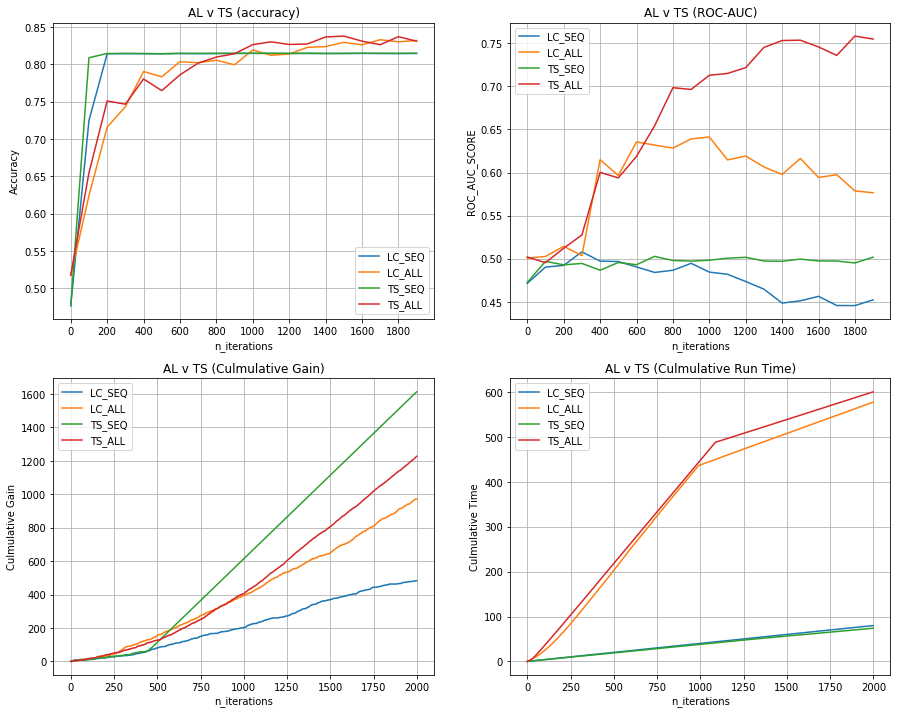

In [9]:
plt.figure(figsize= (15,12))

# only plot 2000 iterations for the purpose of comparison 

plt.subplot(221)
plt.plot(results['LC_SEQ_tra'][::100], label = 'LC_SEQ')
plt.plot(results['LC_ALL_tra'][::100], label = 'LC_ALL')
plt.plot(results['TS_SEQ_tra'][:2000][::100], label = 'TS_SEQ')
plt.plot(results['TS_ALL_tra'][:2000][::100], label = 'TS_ALL')
plt.xticks(numpy.arange(20, step = 2), numpy.arange(2000)[::200])
plt.xlabel('n_iterations')
plt.ylabel('Accuracy')
#plt.ylim(0.4,0.9)
plt.title('AL v TS (accuracy)')
plt.grid(True)
plt.legend()

plt.subplot(222)
plt.plot(results['LC_SEQ_trs'][::100], label = 'LC_SEQ')
plt.plot(results['LC_ALL_trs'][::100], label = 'LC_ALL')
plt.plot(results['TS_SEQ_trs'][:2000][::100], label = 'TS_SEQ')
plt.plot(results['TS_ALL_trs'][:2000][::100], label = 'TS_ALL')
plt.xticks(numpy.arange(20, step = 2), numpy.arange(2000)[::200])
plt.xlabel('n_iterations')
plt.ylabel('ROC_AUC_SCORE')
#plt.ylim(0.4,0.9)
plt.title('AL v TS (ROC-AUC)')
plt.grid(True)
plt.legend()

plt.subplot(223)
plt.plot(numpy.cumsum(results['LC_SEQ_rg']), label = 'LC_SEQ')
plt.plot(numpy.cumsum(results['LC_ALL_rg']), label = 'LC_ALL')
plt.plot(numpy.cumsum(results['TS_SEQ_rg'][:2000]), label = 'TS_SEQ')
plt.plot(numpy.cumsum(results['TS_ALL_rg'][:2000]), label = 'TS_ALL')
plt.ylabel('Culmulative Gain')
plt.xlabel('n_iterations')
#plt.ylim(0,1300)
plt.title('AL v TS (Culmulative Gain)')
plt.grid(True)
plt.legend()

plt.subplot(224)
plt.plot(numpy.cumsum(results['LC_SEQ_time']), label = 'LC_SEQ')
plt.plot(numpy.cumsum(results['LC_ALL_time']), label = 'LC_ALL')
plt.plot(numpy.cumsum(results['TS_SEQ_time'][:2000]), label = 'TS_SEQ')
plt.plot(numpy.cumsum(results['TS_ALL_time'][:2000]), label = 'TS_ALL')
plt.ylabel('Culmulative Time')
plt.xlabel('n_iterations')
#plt.ylim(0,1300)
plt.title('AL v TS (Culmulative Run Time)')
plt.grid(True)
plt.legend()

